In [131]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import warnings
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from AngioMorphPCA.cut_centerline import read_vtk_curve, cut_curve, interpolate_curve, write_vtk_curve
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import os
from AngioMorphPCA.io import makeVtkFile


# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


plt.rcParams['image.cmap'] = 'jet'  # 替换为你想要的 colormap 名称


def interpolate_to_fixed_points(sorted_curve_bs, target_points=120):
    """
    将 (n, m, 3) 形状的 3D 曲线数据插值为 (n, target_points, 3) 形状的数据。
    
    参数:
    sorted_curve_bs (ndarray): 形状为 (n, m, 3) 的 3D 曲线数据，n 是数据数量，m 是原始每条曲线的点数。
    target_points (int): 插值后的目标点数，默认值为 120。
    
    返回:
    ndarray: 形状为 (n, target_points, 3) 的 3D 插值曲线数据。
    """
    n, m, d = sorted_curve_bs.shape  # (79, 119, 3) 的形状
    interpolated_data = np.zeros((n, target_points, d))  # (n, 120, 3)
    
    for i in range(n):
        for j in range(d):  # 对每个维度 (x, y, z) 单独进行插值
            original_points = sorted_curve_bs[i, :, j]
            original_indices = np.linspace(0, 1, m)  # 原始曲线的归一化位置
            target_indices = np.linspace(0, 1, target_points)  # 目标插值的归一化位置
            interpolator = interp1d(original_indices, original_points, kind='linear')
            interpolated_data[i, :, j] = interpolator(target_indices)  # 在目标点上插值
    
    return interpolated_data

def calculate_curve_length(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线的总长度。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        float: 曲线的总长度。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)


    
    # 计算每个差值的欧氏距离，并求和

    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))

    total_length = segment_lengths.sum()
    
    return total_length

def calculate_abscissas(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线每个点的累计弧长（abscissas）。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        numpy.ndarray: 一个形状为 (n,) 的数组，包含每个点对应的累计弧长。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个相邻点对之间的距离
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    
    # 计算累计弧长，起始点的弧长为 0
    abscissas = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    return abscissas

def resample_standardized_curves(standardized_centerlines, standardized_abscissas, m):
    """
    Resample each curve in standardized_centerlines to have exactly m points.

    :param standardized_centerlines: List of (n,3) numpy arrays representing 3D curves.
    :param standardized_abscissas: List of (n,) numpy arrays representing abscissas corresponding to each curve.
    :param m: The number of points each resampled curve should have.
    :return: (new_centerlines, new_abscissas), both resampled to m points.
    """
    new_centerlines = []
    new_abscissas = []

    for i in range(len(standardized_centerlines)):
        curve = standardized_centerlines[i]  # (n,3)
        abscissas = standardized_abscissas[i]  # (n,)

        # 生成新的m个等间距 abscissas
        new_t = np.linspace(abscissas[0], abscissas[-1], m)

        # 分别对 x, y, z 进行插值
        interp_x = interp1d(abscissas, curve[:, 0], kind='cubic', fill_value="extrapolate")
        interp_y = interp1d(abscissas, curve[:, 1], kind='cubic', fill_value="extrapolate")
        interp_z = interp1d(abscissas, curve[:, 2], kind='cubic', fill_value="extrapolate")

        # 计算新的坐标
        new_x = interp_x(new_t)
        new_y = interp_y(new_t)
        new_z = interp_z(new_t)

        # 组合 x, y, z
        new_curve = np.vstack((new_x, new_y, new_z)).T  # (m, 3)

        # 存储结果
        new_centerlines.append(new_curve)
        new_abscissas.append(new_t)

    return new_centerlines, new_abscissas


def align_centerlines_procrustes(original_centerlines):
    num_curves, num_points, dim = original_centerlines.shape
    
    # 选择第一条曲线作为参考
    reference_curve = original_centerlines[0]

    aligned_centerlines = np.zeros_like(original_centerlines)

    for i in range(num_curves):
        _, aligned_curve, _ = procrustes(reference_curve, original_centerlines[i])
        aligned_centerlines[i] = aligned_curve

    return aligned_centerlines

def krzanowski_subspace_similarity(std_pca_components, non_std_pca_components, n_components=10):
    """
    应用 Krzanowski (1979) 方法计算两个 PCA 子空间的相似性。
    使用主角法 (Principal Angles) 计算两个子空间之间的夹角。

    参数:
    - std_pca_components: 标准化 PCA 载荷矩阵 (components_.T)，shape (n_features, n_components)
    - non_std_pca_components: 非标准化 PCA 载荷矩阵 (components_.T)，shape (n_features, n_components)
    - n_components: 比较的主成分个数

    返回:
    - cos_angles: 每个主角的余弦值，越接近1表示两个空间越相似
    """
    # 只取前 n_components 个主成分的载荷矩阵
    U_std = std_pca_components[:, :n_components]
    U_non_std = non_std_pca_components[:, :n_components]

    # 计算主角夹角 (以弧度为单位)
    angles = subspace_angles(U_std, U_non_std)

    # 计算主角的余弦值，越接近1表示空间越相似
    cos_angles = np.cos(angles)

    print("\n=== Krzanowski Subspace Similarity (Principal Angles) ===")
    for i, angle in enumerate(angles):
        print(f"Principal Angle {i+1}: {np.degrees(angle):.2f} degrees, cos(angle): {cos_angles[i]:.4f}")

    return cos_angles

def analyze_pca_relationship(pca_result_1, pca_result_2, n_components=10, label_1="PCA 1", label_2="PCA 2"):
    """
    Analyze the relationship between two PCA results, including:
    1. Pearson correlation coefficients and p-values for each principal component.
    2. Linear regression to estimate the transformation matrix W, with heatmap visualization.
    3. Calculate the sum of absolute values of diagonal and off-diagonal elements in W, and their ratio.

    Parameters:
    - pca_result_1: PCA result from the first setting (numpy array, shape: [n_samples, n_components])
    - pca_result_2: PCA result from the second setting (numpy array, shape: [n_samples, n_components])
    - n_components: Number of PCA components to analyze (default=10)
    - label_1: Label for the first PCA result (e.g., "Non-std 750 points")
    - label_2: Label for the second PCA result (e.g., "Non-std 250 points")

    Returns:
    - W: Transformation matrix obtained from linear regression
    - corr_results: List of (Pearson correlation coefficient, p-value) for each component
    - off_diag_ratio: Ratio of off-diagonal sum to diagonal sum (absolute values)
    """
    n_components = min(n_components, pca_result_1.shape[1], pca_result_2.shape[1])

    print(f"\n=== PCA Component Correlation Analysis ({label_1} vs {label_2}) ===")
    corr_results = []
    for i in range(n_components):
        corr, p_value = pearsonr(pca_result_1[:, i], pca_result_2[:, i])
        corr_results.append((corr, p_value))
        print(f"PC{i+1}: Pearson correlation = {corr:.3f}, p-value = {p_value:.3e}")

    print(f"\n=== PCA Component Transformation Matrix Estimation ({label_1} -> {label_2}) ===")
    model = LinearRegression()
    model.fit(pca_result_1[:, :n_components], pca_result_2[:, :n_components])
    W = model.coef_

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        W,
        annot=False,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.5,
        xticklabels=[f"{label_1} PC{i+1}" for i in range(n_components)],
        yticklabels=[f"{label_2} PC{i+1}" for i in range(n_components)],
        vmin=-1.0,
        vmax=1.0
    )
    plt.title(f"Linear Transformation Matrix (W)\n{label_1} -> {label_2}")
    plt.xlabel(f"{label_1} PCA Components")
    plt.ylabel(f"{label_2} PCA Components")
    plt.tight_layout()
    plt.show()

    diag_sum = np.sum(np.abs(np.diag(W)))
    off_diag_sum = np.sum(np.abs(W)) - diag_sum
    off_diag_ratio = off_diag_sum / diag_sum if diag_sum != 0 else np.nan

    print(f"\n=== Transformation Matrix Statistics ({label_1} -> {label_2}) ===")
    print(f"Sum of absolute diagonal elements: {diag_sum:.4f}")
    print(f"Sum of absolute off-diagonal elements: {off_diag_sum:.4f}")
    print(f"Off-diagonal / Diagonal ratio: {off_diag_ratio:.4f}")

    return W, corr_results, off_diag_ratio






curve_bs = np.load("../geom_aligned_curves_91/geomstats_aligned_to_first_91.npy")
curve_cs = np.load("../geom_aligned_curves_91/geomstats_aligned_to_first_91.npy")
# curve_bs = np.load("../geom_aligned_curves_85/geomstats_aligned_to_first_85.npy")
# curve_cs = np.load("../geom_aligned_curves_85/geomstats_aligned_to_first_85.npy")


# curve_bs = interpolate_to_fixed_points(curve_bs, 75)
# unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves_91/total_files_91.npy")[:curve_bs.shape[0]]

print ("curve_bs.shape:", curve_bs.shape)
# print (unaligned_curvatures.shape)
print ("files length:", files.shape[0])

brava_num = len(curve_bs)

original_centerlines = []
abscissas = []
original_lengths = []
curve_ds = [] # curve_ds是用original_length还原长度的curve_bs,好像难以解释它是怎么求得的
standardized_centerlines = []
standardized_abscissas = []
original_tortuosities = []
original_norms = []

m=75
for i in range(len(files)):
    # print ("files[i]:", files[i])
    original_centerline = Get_simple_vtk("../"+files[i])
    # print ("original_centerline.shape:", original_centerline.shape)
    # print (calculate_curve_length(original_centerline), calculate_curve_length(curve_bs[i]))
    original_lengths.append(calculate_curve_length(original_centerline))
    original_centerlines.append(original_centerline)
    abscissas.append(calculate_abscissas(original_centerline))
    curve_ds.append(curve_bs[i] * calculate_curve_length(original_centerline))
    original_tortuosities.append(calculate_curve_length(original_centerline)/np.linalg.norm(original_centerline[-1]-original_centerline[0]))
    original_norms.append(np.linalg.norm(original_centerline[-1]-original_centerline[0]))
print ("所有中心线的original长度的均值是",np.mean(original_lengths), "标准差是", np.std(original_lengths))

for i in range(len(files)):
    standardized_centerlines.append(original_centerlines[i]*np.mean(original_lengths)/original_lengths[i])
    standardized_abscissas.append(abscissas[i]*np.mean(original_lengths)/original_lengths[i])

resampled_standardized_centerlines, resampled_standardized_abscissas = resample_standardized_curves(standardized_centerlines, standardized_abscissas, m)

original_norms = np.array(original_norms)
original_centerlines = np.array(original_centerlines)
abscissas = np.array(abscissas)
original_lengths = np.array(original_lengths)
original_tortuosities = np.array(original_tortuosities)
curve_ds = np.array(curve_ds)
resampled_standardized_centerlines = np.array(resampled_standardized_centerlines)
resampled_standardized_abscissas = np.array(resampled_standardized_abscissas)

files_label = []
for i in range(len(files)):
    files_label.append("_".join([files[i].split('\\')[-1].split('.')[0].split('_')[0],files[i].split('\\')[-1].split('.')[0].split('_')[-1]]))

# print (files_label)

original_centerlines_copy = np.copy(original_centerlines)
resampled_standardized_centerlines_copy = np.copy(resampled_standardized_centerlines)




curve_bs.shape: (91, 74, 3)
files length: 91
所有中心线的original长度的均值是 74.89519148981852 标准差是 8.036058630489018


In [132]:
import re

# 原始表格数据，你可以直接粘贴进去
raw_data = """
BG001   24  F
BG0002  31  M
BG0003  29  M
BG04    21  M
BG05    35  F
BG06    20  F
BG07    41  F
BG08    27  F
BG09    23  F
BG10    21  F
BG11    44  F
BG12    36  F
BG13    38  M
BG15    27  M
BG17    31  M
BG18    24  M
Set 8   32  M
Set 9   46  M
BG0014  23  F
BG0019  34  M
BG0020  31  M
BG0021  33  M
BG0022  21  M
BH0003  64  F
BH0004  19  M
BH0005  28  F
BH0006  26  F
BH0008  28  M
BH0009  42  F
BH0010  26  F
BH0011  27  F
BH0012  43  M
BH0013  28  M
BH0014  23  F
BH0015  25  F
BH0016  28  M
BH0017  24  F
BH0018  21  F
BH0019  27  F
BH0020  21  M
BH0021  33  F
BH0022  47  F
BH0023  19  F
BH0024  22  M
BH0025  24  M
BH0026  37  F
BH0027  46  F
BH0029  46  M
BH0030  33  F
BH0031  24  F
BH0032  48  M
BH0033  59  M
BH0034  27  F
BH0035  24  F
BH0036  29  F
BH0037  50  F
BH0038  22  F
BH0039  42  F
BH0040  30  F
BI0001  22  M
BH0002  25  F
"""

# 解析数据成字典
age_sex_dict = {}

for line in raw_data.strip().splitlines():
    parts = line.split()
    code, age, sex = parts[0], int(parts[1]), parts[2]

    # 处理BG001 -> BG0001 这种情况
    match = re.match(r"(BG|BH|BI)(\d+)", code)
    if match:
        prefix, number = match.groups()
        code = f"{prefix}{int(number):04d}"  # 转成4位数字格式，比如 BG001 -> BG0001

    age_sex_dict[code] = {"AGE": age, "SEX": sex}

print(age_sex_dict)


{'BG0001': {'AGE': 24, 'SEX': 'F'}, 'BG0002': {'AGE': 31, 'SEX': 'M'}, 'BG0003': {'AGE': 29, 'SEX': 'M'}, 'BG0004': {'AGE': 21, 'SEX': 'M'}, 'BG0005': {'AGE': 35, 'SEX': 'F'}, 'BG0006': {'AGE': 20, 'SEX': 'F'}, 'BG0007': {'AGE': 41, 'SEX': 'F'}, 'BG0008': {'AGE': 27, 'SEX': 'F'}, 'BG0009': {'AGE': 23, 'SEX': 'F'}, 'BG0010': {'AGE': 21, 'SEX': 'F'}, 'BG0011': {'AGE': 44, 'SEX': 'F'}, 'BG0012': {'AGE': 36, 'SEX': 'F'}, 'BG0013': {'AGE': 38, 'SEX': 'M'}, 'BG0015': {'AGE': 27, 'SEX': 'M'}, 'BG0017': {'AGE': 31, 'SEX': 'M'}, 'BG0018': {'AGE': 24, 'SEX': 'M'}, 'Set': {'AGE': 9, 'SEX': '46'}, 'BG0014': {'AGE': 23, 'SEX': 'F'}, 'BG0019': {'AGE': 34, 'SEX': 'M'}, 'BG0020': {'AGE': 31, 'SEX': 'M'}, 'BG0021': {'AGE': 33, 'SEX': 'M'}, 'BG0022': {'AGE': 21, 'SEX': 'M'}, 'BH0003': {'AGE': 64, 'SEX': 'F'}, 'BH0004': {'AGE': 19, 'SEX': 'M'}, 'BH0005': {'AGE': 28, 'SEX': 'F'}, 'BH0006': {'AGE': 26, 'SEX': 'F'}, 'BH0008': {'AGE': 28, 'SEX': 'M'}, 'BH0009': {'AGE': 42, 'SEX': 'F'}, 'BH0010': {'AGE': 26, 

In [133]:
import re
import os
import glob
import pandas as pd

# 提取tag的函数：从文件名开头提取形如BG0001、BH0021、BI0003等tag
def extract_tag(file):
    filename = os.path.basename(file)
    match = re.match(r'([A-Z]{2}[0-9]{4})', filename)
    return match.group(1) if match else None

# 计算索引匹配列表的函数：返回一个列表，成对位置互相标记，未配对为 -1
def compute_pair_indices(files):
    tags = [extract_tag(f) for f in files]

    index_map = {}
    for i, tag in enumerate(tags):
        if tag in index_map:
            index_map[tag].append(i)
        else:
            index_map[tag] = [i]

    result = [-1] * len(files)
    for indices in index_map.values():
        if len(indices) == 2:
            result[indices[0]] = indices[1]
            result[indices[1]] = indices[0]

    return result

# 获取详细配对信息的函数：返回列表、DataFrame和字典三种形式
def get_pair_indices(files):
    tags = [extract_tag(f) for f in files]

    index_map = {}
    for i, tag in enumerate(tags):
        if tag in index_map:
            index_map[tag].append(i)
        else:
            index_map[tag] = [i]

    result_list = []
    for tag, indices in index_map.items():
        if len(indices) == 1:
            result_list.append([tag, indices[0], -1])
        elif len(indices) == 2:
            result_list.append([tag, indices[0], indices[1]])

    result_df = pd.DataFrame(result_list, columns=['tag', 'idx_1', 'idx_2'])
    result_dict = {row['tag']: (row['idx_1'], row['idx_2']) for _, row in result_df.iterrows()}

    return result_list, result_df, result_dict


# ======== 示例用法 ========

# 计算配对结果
paring_result = compute_pair_indices(files)

# 获取详细配对信息
pairing_result_list, pairing_result_df, pairing_result_dict = get_pair_indices(files)

# 输出未配对文件的索引和路径
unpaired_indices = [i for i, v in enumerate(paring_result) if v == -1]
unpaired_files = [files[i] for i in unpaired_indices]

print("未配对文件索引:", unpaired_indices)
print("未配对文件路径:")
for f in unpaired_files:
    print(f)

# 可选：输出 DataFrame 查看配对情况
print("\n配对 DataFrame:")
print(pairing_result_df)


import itertools

def compute_relative_difference(val1, val2):
    return abs(val1 - val2) / ((val1 + val2) / 2)

def analyze_similarity(result_dict, original_lengths, original_tortuosities):
    # 计算相同tag下的相对差异
    paired_length_diff = []
    paired_tortuosity_diff = []

    for tag, (idx1, idx2) in result_dict.items():
        if idx2 == -1:
            continue
        l1, l2 = original_lengths[idx1], original_lengths[idx2]
        t1, t2 = original_tortuosities[idx1], original_tortuosities[idx2]

        paired_length_diff.append(compute_relative_difference(l1, l2))
        paired_tortuosity_diff.append(compute_relative_difference(t1, t2))

    # 计算随机任意两条曲线的相对差异
    all_length_diff = []
    all_tortuosity_diff = []

    indices = list(range(len(original_lengths)))
    for idx1, idx2 in itertools.combinations(indices, 2):
        l1, l2 = original_lengths[idx1], original_lengths[idx2]
        t1, t2 = original_tortuosities[idx1], original_tortuosities[idx2]

        all_length_diff.append(compute_relative_difference(l1, l2))
        all_tortuosity_diff.append(compute_relative_difference(t1, t2))

    # 转换为numpy数组以便计算统计信息
    paired_length_diff = np.array(paired_length_diff)
    paired_tortuosity_diff = np.array(paired_tortuosity_diff)
    all_length_diff = np.array(all_length_diff)
    all_tortuosity_diff = np.array(all_tortuosity_diff)

    # 统计信息
    stats = {
        'paired_length_mean': paired_length_diff.mean(),
        'paired_length_median': np.median(paired_length_diff),
        'paired_length_std': paired_length_diff.std(),

        'all_length_mean': all_length_diff.mean(),
        'all_length_median': np.median(all_length_diff),
        'all_length_std': all_length_diff.std(),

        'paired_tortuosity_mean': paired_tortuosity_diff.mean(),
        'paired_tortuosity_median': np.median(paired_tortuosity_diff),
        'paired_tortuosity_std': paired_tortuosity_diff.std(),

        'all_tortuosity_mean': all_tortuosity_diff.mean(),
        'all_tortuosity_median': np.median(all_tortuosity_diff),
        'all_tortuosity_std': all_tortuosity_diff.std(),
    }

    return stats, paired_length_diff, paired_tortuosity_diff, all_length_diff, all_tortuosity_diff


stats, paired_length_diff, paired_tortuosity_diff, all_length_diff, all_tortuosity_diff = analyze_similarity(
    pairing_result_dict, original_lengths, original_tortuosities)

print (pd.DataFrame([stats]))


merged_result = {}

for tag, indices in pairing_result_dict.items():
    age_sex_info = age_sex_dict.get(tag, {'AGE': None, 'SEX': None})
    merged_result[tag] = {
        'indices': indices,
        'AGE': age_sex_info['AGE'],
        'SEX': age_sex_info['SEX']
    }





未配对文件索引: [26, 54, 57, 70, 75]
未配对文件路径:
brava_cut_mirrored\BG0021_ICA_R.vtk
brava_cut_mirrored\BH0023_ICA_L.vtk
brava_cut_mirrored\BH0025_ICA_R.vtk
brava_cut_mirrored\BH0036_ICA_R.vtk
brava_cut_mirrored\BH0040_ICA_R.vtk

配对 DataFrame:
       tag  idx_1  idx_2
0   BG0001      0      1
1   BG0004      2      3
2   BG0006      4      5
3   BG0007      6      7
4   BG0008      8      9
5   BG0009     10     11
6   BG0010     12     13
7   BG0011     14     15
8   BG0012     16     17
9   BG0017     18     19
10  BG0018     20     21
11  BG0019     22     23
12  BG0020     24     25
13  BG0021     26     -1
14  BG0022     27     28
15  BH0005     29     30
16  BH0006     31     32
17  BH0009     33     34
18  BH0010     35     36
19  BH0011     37     38
20  BH0013     39     40
21  BH0014     41     42
22  BH0016     43     44
23  BH0017     45     46
24  BH0018     47     48
25  BH0019     49     50
26  BH0020     51     52
27  BH0021     53     84
28  BH0023     54     -1
29  BH0024     5

In [134]:
import os
import re
import pandas as pd

# 提取 tag 的函数
def extract_tag(file):
    filename = os.path.basename(file)
    match = re.match(r'([A-Z]{2}[0-9]{4})', filename)
    return match.group(1) if match else None

# 解析文件得到 tag，并从 age_sex_dict 取年龄性别
data = []
seen_tags = set()  # 记录已经处理过的 tag，避免重复统计

for file in files:
    tag = extract_tag(file)
    if tag and tag in age_sex_dict and tag not in seen_tags:
        age = age_sex_dict[tag]['AGE']
        sex = age_sex_dict[tag]['SEX']
        data.append({'tag': tag, 'age': age, 'sex': sex})
        seen_tags.add(tag)

df = pd.DataFrame(data)

# 统计性别人数
sex_counts = df['sex'].value_counts()
print("性别人数统计：")
print(sex_counts)

# 计算年龄分布
age_mean = df['age'].mean()
age_std = df['age'].std()
age_median = df['age'].median()

print(f"\n年龄分布：")
print(f"均值: {age_mean:.2f}")
print(f"标准差: {age_std:.2f}")
print(f"中位数: {age_median:.2f}")

# 按性别分组，计算年龄的统计信息
age_sex_stats = df.groupby('sex')['age'].agg(['count', 'mean', 'std', 'median'])

print(f"\n年龄与性别的交叉信息：")
print(age_sex_stats)


性别人数统计：
sex
F    30
M    17
Name: count, dtype: int64

年龄分布：
均值: 29.74
标准差: 9.02
中位数: 27.00

年龄与性别的交叉信息：
     count       mean       std  median
sex                                    
F       30  29.900000  8.627742    27.0
M       17  29.470588  9.938043    28.0


In [135]:
# low_tortuosity_standardized_centerlines = resampled_standardized_centerlines[original_tortuosities < 1.8]
# high_tortuosity_standardized_centerlines = resampled_standardized_centerlines[original_tortuosities > 1.8]

# low_tortuosity_standardized_mean = np.mean(low_tortuosity_standardized_centerlines, axis=0)
# high_tortuosity_standardized_mean = np.mean(high_tortuosity_standardized_centerlines, axis=0)

# low_t_standardized_mean_tortuosity = calculate_curve_length(low_tortuosity_standardized_mean)/np.linalg.norm(low_tortuosity_standardized_mean[-1]-low_tortuosity_standardized_mean[0])
# high_t_standardized_mean_tortuosity = calculate_curve_length(high_tortuosity_standardized_mean)/np.linalg.norm(high_tortuosity_standardized_mean[-1]-high_tortuosity_standardized_mean[0])

# # 分别画出两类曲线
# plt.figure(figsize=(3,5),dpi=100)

# for curve in low_tortuosity_standardized_centerlines:
#     plt.plot(curve[:, 1], -curve[:, 2], c='b', alpha=0.1)
# for curve in high_tortuosity_standardized_centerlines:
#     plt.plot(curve[:, 1], -curve[:, 2], c='r', alpha=0.1)

# plt.plot(low_tortuosity_standardized_mean[:, 1], -low_tortuosity_standardized_mean[:, 2], c='b', label="Low Tortuosity Mean",linewidth=2)
# plt.plot(high_tortuosity_standardized_mean[:, 1], -high_tortuosity_standardized_mean[:, 2], c='r', label="High Tortuosity Mean",linewidth=2)
# plt.plot(np.mean(resampled_standardized_centerlines, axis=0)[:, 1], 
#          -np.mean(resampled_standardized_centerlines, axis=0)[:, 2], 
#          c='k', 
#          label="Overall Mean",
#          linestyle='--')
# plt.title("Low Mean T:{}, High Mean T:{}".format(round(low_t_standardized_mean_tortuosity,2), round(high_t_standardized_mean_tortuosity,2)))
# plt.legend()
# plt.show()


mean_estimate_tortuosity: 1.5791603084723422
mean_estimate.shape: (74, 3)
curve_bs.shape: (91, 74, 3)


<Figure size 600x200 with 0 Axes>

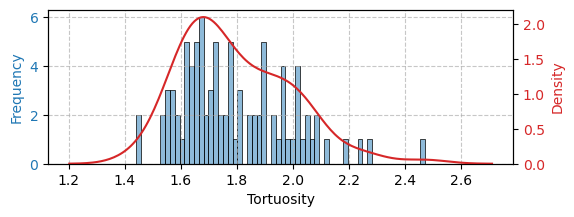

<Figure size 600x200 with 0 Axes>

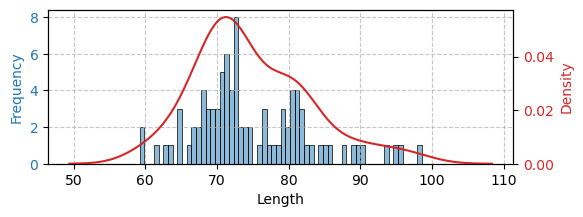

<Figure size 600x200 with 0 Axes>

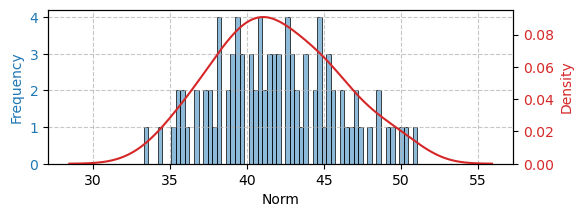

In [136]:
k_sampling_points = 75

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=True
)

curves_r3.equip_with_metric(SRVMetric)
curves_r3.equip_with_group_action(("rotations", "reparametrizations"))
curves_r3.equip_with_quotient()
mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_

mean_estimate_tortuosity = calculate_curve_length(mean_estimate)/np.linalg.norm(mean_estimate[-1]-mean_estimate[0])
print ("mean_estimate_tortuosity:", mean_estimate_tortuosity)


print ("mean_estimate.shape:", mean_estimate.shape) # mean_estimate.shape: (120, 3)
print ("curve_bs.shape:", curve_cs.shape) # curve_bs.shape: (79, 120, 3)
g_dist_to_frechet = []
for i in range(len(curve_cs)):
    g_dist_to_frechet.append(curves_r3.metric.dist(mean_estimate, curve_cs[i]))
g_dist_to_frechet = np.array(g_dist_to_frechet)


bins = 60
# plt.figure(figsize=(6, 2))
# fig, ax1 = plt.subplots(figsize=(6, 2))

# # 直方图（频数）
# sns.histplot(g_dist_to_frechet, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
# ax1.set_xlabel("Distance to Fréchet Mean")
# ax1.set_ylabel("Frequency", color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')

# # KDE曲线（密度）- 第二个y轴
# ax2 = ax1.twinx()
# sns.kdeplot(g_dist_to_frechet, ax=ax2, color='tab:red')
# ax2.set_ylabel("Density", color='tab:red')
# ax2.tick_params(axis='y', labelcolor='tab:red')

# ax1.grid(linestyle='--', alpha=0.7)
# # plt.title("Histogram + KDE Plot of Distances to Fréchet Mean")
# plt.show()

plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_tortuosities, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Tortuosity")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_tortuosities, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
# plt.title("Histogram + KDE Plot of Tortuosity")
plt.show()

plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_lengths, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Length")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_lengths, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
# plt.title("Histogram + KDE Plot of Length")
plt.show()


plt.figure(figsize=(6, 2))
fig, ax1 = plt.subplots(figsize=(6, 2))

sns.histplot(original_norms, bins=bins, stat='count', alpha=0.5, ax=ax1, color='tab:blue')
ax1.set_xlabel("Norm")
ax1.set_ylabel("Frequency", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
sns.kdeplot(original_norms, ax=ax2, color='tab:red')
ax2.set_ylabel("Density", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.grid(linestyle='--', alpha=0.7)
# plt.title("Histogram + KDE Plot of Norm")
plt.show()



=======GMM========


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Length BIC: 650.7303720464218
Tortuosity BIC: -29.74213766769266


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


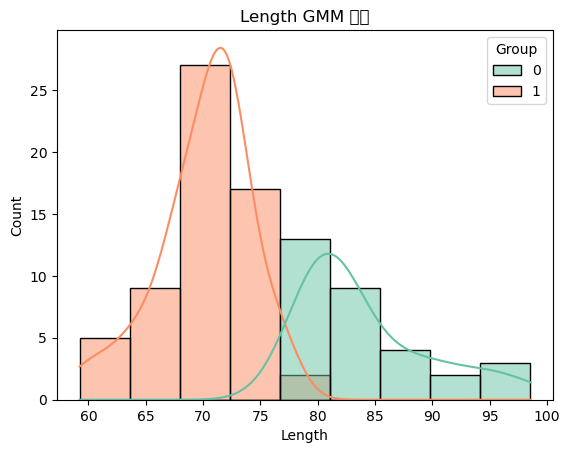

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


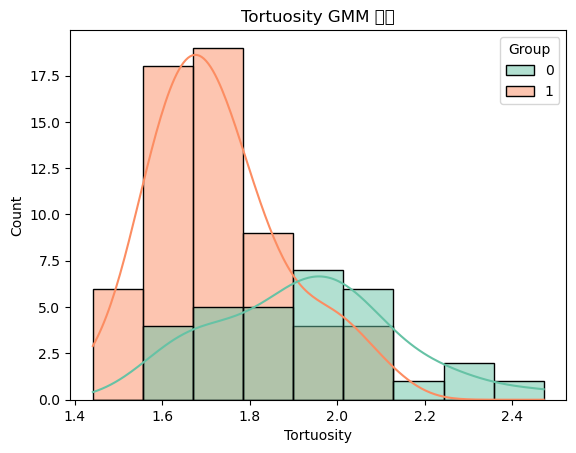

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


=======GMM========
[1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1
 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0
 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0]
Low Length Group Norm Mean: 43.943127041794135
High Length Group Norm Mean: 40.841206525878
T-test: t = 3.541, p = 0.001
indices: (89, 90)


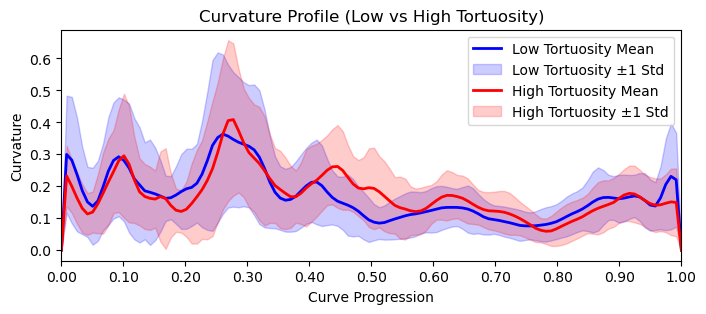

Low Tortuosity Group Length Mean: 71.371
High Tortuosity Group Length Mean: 80.039
T-test: t = -5.553, p = 6.488e-07


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

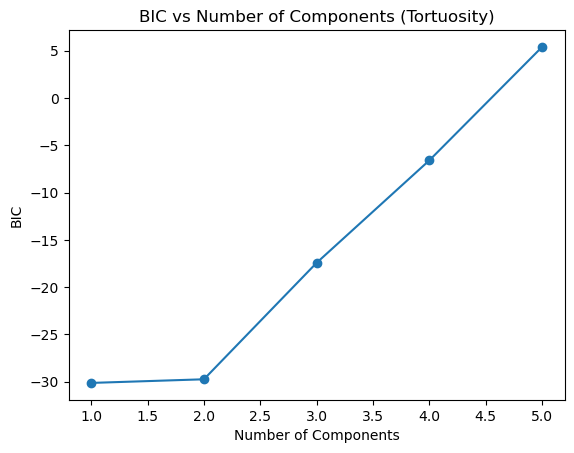

In [137]:
print ("=======GMM========")
from sklearn.mixture import GaussianMixture

# Length 双峰验证
gmm_length = GaussianMixture(n_components=2, random_state=0)
gmm_length.fit(original_lengths.reshape(-1, 1))
length_labels = gmm_length.predict(original_lengths.reshape(-1, 1))

# Tortuosity 双峰验证
gmm_tortuosity = GaussianMixture(n_components=2, random_state=0)
gmm_tortuosity.fit(original_tortuosities.reshape(-1, 1))
tortuosity_labels = gmm_tortuosity.predict(original_tortuosities.reshape(-1, 1))

print("Length BIC:", gmm_length.bic(original_lengths.reshape(-1, 1)))
print("Tortuosity BIC:", gmm_tortuosity.bic(original_tortuosities.reshape(-1, 1)))


df = pd.DataFrame({
    'Length': original_lengths,
    'Group': length_labels
})
df['Tortuosity'] = original_tortuosities

sns.histplot(data=df, x='Length', kde=True, hue='Group', palette='Set2')
plt.title("Length GMM 分组")
plt.show()

sns.histplot(data=df, x='Tortuosity', kde=True, hue='Group', palette='Set2')
plt.title("Tortuosity GMM 分组")
plt.show()


print ("=======GMM========")

print (tortuosity_labels)
low_group_norms = original_norms[length_labels == 0]
high_group_norms = original_norms[length_labels == 1]

print("Low Length Group Norm Mean:", np.mean(low_group_norms))
print("High Length Group Norm Mean:", np.mean(high_group_norms))

from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(low_group_norms, high_group_norms, equal_var=False)
print(f"T-test: t = {t_stat:.3f}, p = {p_value:.3f}")

print ("indices:", indices)

low_c = []
high_c = []
low_t = []
high_t = []

for i in range(len(original_centerlines_copy)):
    c,t = compute_curvature_and_torsion(original_centerlines_copy[i])
    if tortuosity_labels[i] == 0:
        high_c.append(c)
        high_t.append(t)
    else:
        low_c.append(c)
        low_t.append(t)

# 假设low_c 和 high_c 已经计算完成，形状均为 (n_curves, n_points_per_curve)
low_c = np.array(low_c)
high_c = np.array(high_c)
low_t = np.array(low_t)
high_t = np.array(high_t)

# 计算每类曲线的均值和标准差
low_c_mean = np.mean(low_c, axis=0)
low_c_std = np.std(low_c, axis=0)
low_t_mean = np.mean(low_t, axis=0)
low_t_std = np.std(low_t, axis=0)

high_c_mean = np.mean(high_c, axis=0)
high_c_std = np.std(high_c, axis=0)
high_t_mean = np.mean(high_t, axis=0)
high_t_std = np.std(high_t, axis=0)

def set_x_ticks_normalized(ax,x_array,num=5):
    ax.set_xlim(0, len(x_array) - 1)
    ax.set_xticks(np.linspace(0, len(x_array)-1, num=num))
    ax.set_xticklabels(['{:.2f}'.format(x) for x in np.linspace(0, 1, num=num)])
    ax.autoscale(enable=True, axis='x', tight=True)
    
# 绘图
plt.figure(figsize=(8, 3))

# 绘制 Low Tortuosity
plt.plot(low_c_mean, color='b', label='Low Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(low_c_mean)),
                 low_c_mean - low_c_std,
                 low_c_mean + low_c_std,
                 color='b', alpha=0.2, label='Low Tortuosity ±1 Std')

# 绘制 High Tortuosity
plt.plot(high_c_mean, color='r', label='High Tortuosity Mean', linewidth=2)
plt.fill_between(range(len(high_c_mean)),
                 high_c_mean - high_c_std,
                 high_c_mean + high_c_std,
                 color='r', alpha=0.2, label='High Tortuosity ±1 Std')

plt.xlabel("Curve Progression")
plt.ylabel("Curvature")
plt.title("Curvature Profile (Low vs High Tortuosity)")
plt.legend()
plt.xlim(0, len(high_c_mean) - 1)
plt.xticks(
    np.linspace(0, len(high_c_mean) - 1, num=11),
    ['{:.2f}'.format(x) for x in np.linspace(0, 1, num=11)]
)
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

import numpy as np
from scipy.stats import ttest_ind

# 转为 numpy 数组以便索引操作
original_lengths = np.array(original_lengths)
tortuosity_labels = np.array(tortuosity_labels)
original_tortuosities = np.array(original_tortuosities)

# 判断 tortuosity_labels=0 和 1 对应的 tortuosity 均值，决定是否交换标签
mean_0 = np.mean(original_tortuosities[tortuosity_labels == 0])
mean_1 = np.mean(original_tortuosities[tortuosity_labels == 1])

if mean_0 > mean_1:
    tortuosity_labels = 1 - tortuosity_labels  # 交换，使得 0 始终表示低 tortuosity，1 表示高 tortuosity

# 按照 tortuosity 分组提取 length
low_tortuosity_lengths = original_lengths[tortuosity_labels == 0]
high_tortuosity_lengths = original_lengths[tortuosity_labels == 1]

# 计算均值
low_tortuosity_mean = np.mean(low_tortuosity_lengths)
high_tortuosity_mean = np.mean(high_tortuosity_lengths)

# t 检验：两组是否存在显著差异
t_stat, p_value = ttest_ind(low_tortuosity_lengths, high_tortuosity_lengths, equal_var=False)

print(f"Low Tortuosity Group Length Mean: {low_tortuosity_mean:.3f}")
print(f"High Tortuosity Group Length Mean: {high_tortuosity_mean:.3f}")
print(f"T-test: t = {t_stat:.3f}, p = {p_value:.3e}")

from sklearn.mixture import GaussianMixture

bic_scores = []
n_components_range = range(1, 6)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(original_tortuosities.reshape(-1, 1))
    bic_scores.append(gmm.bic(original_tortuosities.reshape(-1, 1)))

plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("BIC")
plt.title("BIC vs Number of Components (Tortuosity)")
plt.show()

# # 绘图
# plt.figure(figsize=(8, 3))

# 绘制 Low Tortuosity
# plt.plot(low_t_mean, color='b', label='Low Tortuosity Mean', linewidth=2)
# plt.fill_between(range(len(low_t_mean)),
#                  low_t_mean - low_t_std,
#                  low_t_mean + low_t_std,
#                  color='b', alpha=0.2, label='Low Tortuosity ±1 Std')

# # 绘制 High Tortuosity
# plt.plot(high_t_mean, color='r', label='High Tortuosity Mean', linewidth=2)
# plt.fill_between(range(len(high_t_mean)),
#                  high_t_mean - high_t_std,
#                  high_t_mean + high_t_std,
#                  color='r', alpha=0.2, label='High Tortuosity ±1 Std')

# plt.xlabel("Curve Progression")
# plt.ylabel("Torsion")
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.title("Torsion Profile (Low vs High Tortuosity)")
# plt.legend()
# plt.show()


d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


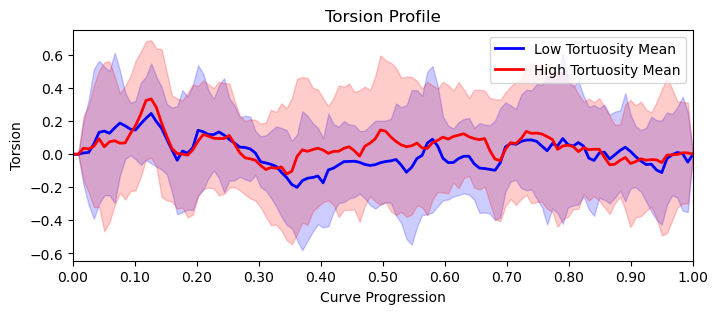

In [138]:
import numpy as np
import matplotlib.pyplot as plt

axes_labels = ['X', 'Y', 'Z']
flip_combinations = [
    # (1, 1, 1),    # 不反转
    (1, 1, 1),   # 反转 X
    # (1, -1, 1),   # 反转 Y
    # (1, 1, -1),   # 反转 Z
    # (-1, -1, 1),  # 反转 X, Y
    # (-1, 1, -1),  # 反转 X, Z
    # (1, -1, -1),  # 反转 Y, Z
    # (-1, -1, -1), # 反转 X, Y, Z
]

for flip_x, flip_y, flip_z in flip_combinations:
    low_c = []
    high_c = []
    low_t = []
    high_t = []

    for i in range(len(original_centerlines_copy)):
        curve = original_centerlines_copy[i].copy()
        curve[:, 0] *= flip_x
        curve[:, 1] *= flip_y
        curve[:, 2] *= flip_z

        c, t = compute_curvature_and_torsion(curve)

        if tortuosity_labels[i] == 0:
            high_c.append(c)
            high_t.append(t)
        else:
            low_c.append(c)
            low_t.append(t)

    low_c = np.array(low_c)
    high_c = np.array(high_c)
    low_t = np.array(low_t)
    high_t = np.array(high_t)

    low_c_mean = np.mean(low_c, axis=0)
    low_c_std = np.std(low_c, axis=0)
    low_t_mean = np.mean(low_t, axis=0)
    low_t_std = np.std(low_t, axis=0)

    high_c_mean = np.mean(high_c, axis=0)
    high_c_std = np.std(high_c, axis=0)
    high_t_mean = np.mean(high_t, axis=0)
    high_t_std = np.std(high_t, axis=0)


    # 绘制 Torsion Profile
    plt.figure(figsize=(8, 3))
    plt.plot(low_t_mean, color='b', label='Low Tortuosity Mean', linewidth=2)
    plt.fill_between(range(len(low_t_mean)),
                     low_t_mean - low_t_std,
                     low_t_mean + low_t_std,
                     color='b', alpha=0.2)
    plt.plot(high_t_mean, color='r', label='High Tortuosity Mean', linewidth=2)
    plt.fill_between(range(len(high_t_mean)),
                     high_t_mean - high_t_std,
                     high_t_mean + high_t_std,
                     color='r', alpha=0.2)
    plt.xlabel("Curve Progression")
    plt.ylabel("Torsion")
    # plt.title(f"Torsion Profile (Flip X:{flip_x}, Y:{flip_y}, Z:{flip_z})")
    plt.title(f"Torsion Profile")
    plt.legend()
    plt.xlim(0, len(high_c_mean) - 1)
    plt.xticks(
        np.linspace(0, len(high_c_mean) - 1, num=11),
        ['{:.2f}'.format(x) for x in np.linspace(0, 1, num=11)]
    )
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.show()


In [139]:
from scipy.stats import pearsonr

# 计算 original_norms 和 original_tortuosities 之间的相关系数
corr_norm_tort, p_value_norm = pearsonr(original_norms, original_tortuosities)
print(f"original_norms vs Tortuosity 相关系数: {corr_norm_tort:.3f}, p值: {p_value_norm:.3e}")

# 计算 original_lengths 和 original_tortuosities 之间的相关系数
corr_length_tort, p_value_length = pearsonr(original_lengths, original_tortuosities)
print(f"Length vs Tortuosity 相关系数: {corr_length_tort:.3f}, p值: {p_value_length:.3e}")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.column_stack([original_lengths, original_norms]))
X_scaled = sm.add_constant(X_scaled)
y = original_tortuosities

model_scaled = sm.OLS(y, X_scaled).fit()
print(model_scaled.summary())



original_norms vs Tortuosity 相关系数: -0.445, p值: 9.940e-06
Length vs Tortuosity 相关系数: 0.603, p值: 2.547e-10
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     4255.
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           2.77e-88
Time:                        21:15:16   Log-Likelihood:                 228.05
No. Observations:                  91   AIC:                            -450.1
Df Residuals:                      88   BIC:                            -442.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

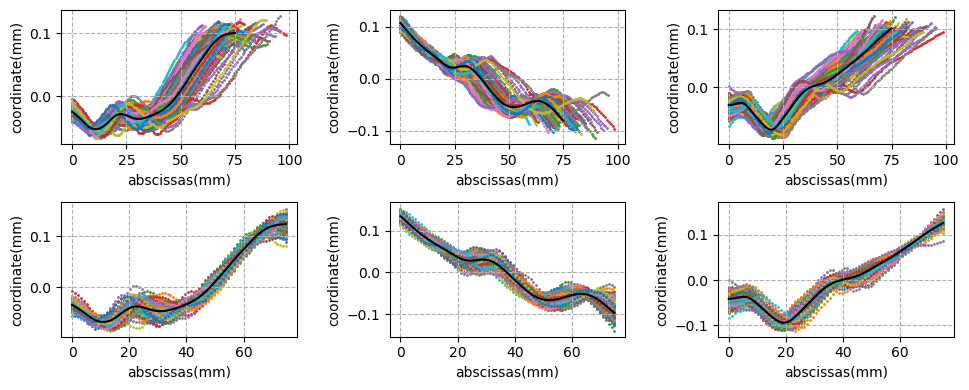

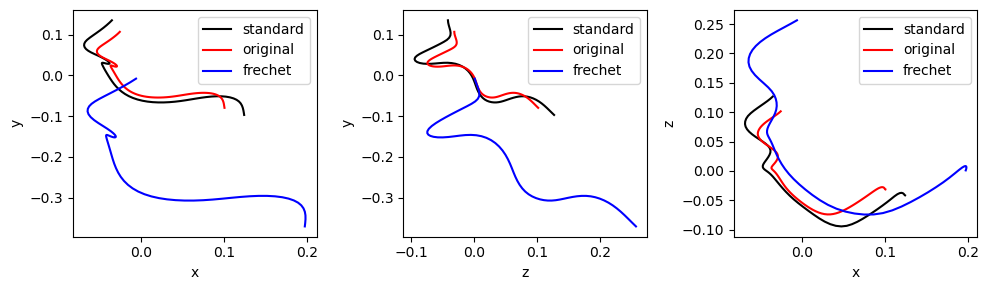

length of resampled_standardized_mean_cl: 0.5209927386963885
length of original_mean_cl: 0.4183343070547611
length of frechet mean shape: 0.7700664228159282
tortuosity of resampled standardized mean curve:
1.5895005264264803
tortuosity of original mean curve:
1.601440227805145
tortuosity of frechet mean curve:
1.5791603084723422
Estimated original length: 66.42735040233677
Estimated original length (non-standardized): 66.7894225983376
curve_bs_length: 0.9803194163036234 0.0036810061957551457


In [140]:
# After aligning the curves, we can visualize the aligned curves in 3D space.

original_centerlines = align_centerlines_procrustes(original_centerlines)
resampled_standardized_centerlines = align_centerlines_procrustes(resampled_standardized_centerlines)

aligned_original_mean_cl = np.mean(original_centerlines, axis=0)
# aligned_original_mean_abscissas = calculate_abscissas(aligned_original_mean_cl)
aligned_original_mean_abscissas = np.mean(abscissas, axis=0)
aligned_resampled_standardized_mean_cl = np.mean(resampled_standardized_centerlines, axis=0)
# aligned_resampled_standardized_mean_abscissas = calculate_abscissas(aligned_resampled_standardized_mean_cl)
aligned_resampled_standardized_mean_abscissas = np.mean(resampled_standardized_abscissas, axis=0)


# 可视化对齐后的曲线
fig = plt.figure(figsize=(10,4), dpi=100)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


for i in range(len(original_centerlines)):
    ax1.scatter(abscissas[i], original_centerlines[i][:, 0], marker='o', s=1)
    ax2.scatter(abscissas[i], original_centerlines[i][:, 1], marker='o', s=1)
    ax3.scatter(abscissas[i], original_centerlines[i][:, 2], marker='o', s=1)
    ax4.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 0], marker='o', s=1)
    ax5.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 1], marker='o', s=1)
    ax6.scatter(resampled_standardized_abscissas[i], resampled_standardized_centerlines[i][:, 2], marker='o', s=1)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel("abscissas(mm)")
    ax.set_ylabel("coordinate(mm)")
    ax.grid(linestyle="--")

ax1.plot(aligned_original_mean_abscissas, aligned_original_mean_cl[:, 0], color='k', label='mean')
ax2.plot(aligned_original_mean_abscissas, aligned_original_mean_cl[:, 1], color='k', label='mean')
ax3.plot(aligned_original_mean_abscissas, aligned_original_mean_cl[:, 2], color='k', label='mean')
ax4.plot(aligned_resampled_standardized_mean_abscissas, aligned_resampled_standardized_mean_cl[:, 0], color='k', label='mean')
ax5.plot(aligned_resampled_standardized_mean_abscissas, aligned_resampled_standardized_mean_cl[:, 1], color='k', label='mean')
ax6.plot(aligned_resampled_standardized_mean_abscissas, aligned_resampled_standardized_mean_cl[:, 2], color='k', label='mean')


plt.tight_layout()
plt.show()


adjust_mean_k =1
fig = plt.figure(figsize=(10,3), dpi=100)
ax1 = fig.add_subplot(131)
ax1.plot(aligned_resampled_standardized_mean_cl[:,0],aligned_resampled_standardized_mean_cl[:,1],color='k',label='standard')
ax1.plot(aligned_original_mean_cl[:,0],aligned_original_mean_cl[:,1],color='r',label='original')
# ax1_twin = ax1.twinx()
# ax1_twin.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
ax1.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,1]*adjust_mean_k,color='b',label='frechet')
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax2 = fig.add_subplot(132)
ax2.plot(aligned_resampled_standardized_mean_cl[:,2][::-1],aligned_resampled_standardized_mean_cl[:,1][::-1],color='k',label='standard')
ax2.plot(aligned_original_mean_cl[:,2][::-1],aligned_original_mean_cl[:,1][::-1],color='r',label='original')
# ax2_twin = ax2.twinx()
# ax2_twin.plot(mean_estimate[:,2][::-1]*adjust_mean_k, mean_estimate[:,1][::-1]*adjust_mean_k,color='b',label='frechet')
ax2.plot(mean_estimate[:,2][::-1]*adjust_mean_k, mean_estimate[:,1][::-1]*adjust_mean_k,color='b',label='frechet')
ax2.legend()
ax2.set_xlabel("z")
ax2.set_ylabel("y")
ax3 = fig.add_subplot(133)
ax3.plot(aligned_resampled_standardized_mean_cl[:,0],aligned_resampled_standardized_mean_cl[:,2][::-1],color='k',label='standard')
ax3.plot(aligned_original_mean_cl[:,0],aligned_original_mean_cl[:,2][::-1],color='r',label='original')
# ax3_twin = ax3.twinx()
# ax3_twin.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,2][::-1]*adjust_mean_k,color='b',label='frechet')
ax3.plot(mean_estimate[:,0]*adjust_mean_k,mean_estimate[:,2][::-1]*adjust_mean_k,color='b',label='frechet')
ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("z")
plt.tight_layout()
plt.show()

print ("length of resampled_standardized_mean_cl:", calculate_curve_length(aligned_resampled_standardized_mean_cl))
print ("length of original_mean_cl:", calculate_curve_length(aligned_original_mean_cl))
print ("length of frechet mean shape:", calculate_curve_length(adjust_mean_k*mean_estimate))
print ("tortuosity of resampled standardized mean curve:")
print(calculate_curve_length(aligned_resampled_standardized_mean_cl)/np.linalg.norm(aligned_resampled_standardized_mean_cl[-1]-aligned_resampled_standardized_mean_cl[0]))
print ("tortuosity of original mean curve:")
print(calculate_curve_length(aligned_original_mean_cl)/np.linalg.norm(aligned_original_mean_cl[-1]-aligned_original_mean_cl[0]))
print ("tortuosity of frechet mean curve:")
print(calculate_curve_length(mean_estimate)/np.linalg.norm(mean_estimate[-1]-mean_estimate[0]))

orig_std_lengths = 75.0
aligned_std_lengths = np.array([calculate_curve_length(cl) for cl in align_centerlines_procrustes(resampled_standardized_centerlines)])
std_scaling_factor = orig_std_lengths / np.mean(aligned_std_lengths)
estimated_std_original_length = std_scaling_factor * calculate_curve_length(aligned_resampled_standardized_mean_cl)
print("Estimated original length:", estimated_std_original_length)

# original_lengths = np.array([calculate_curve_length(cl) for cl in original_centerlines])
aligned_nonstd_lengths = np.array([calculate_curve_length(cl) for cl in original_centerlines])
nonstd_scaling_factor = 75 / np.mean(aligned_nonstd_lengths)
estimated_nonstd_original_length = nonstd_scaling_factor * calculate_curve_length(aligned_original_mean_cl)
print("Estimated original length (non-standardized):", estimated_nonstd_original_length)

curve_bs_length = []
for i in range(len(curve_bs)):
    curve_bs_length.append(calculate_curve_length(curve_bs[i]))
print ("curve_bs_length:", np.mean(curve_bs_length), np.std(curve_bs_length))

interpolated_std_centerlines.shape: (91, 750, 3)
interval:, 0.1 explained_variance_ratio_: [0.27200754 0.17755642 0.11416203 0.09229917 0.07070326 0.05362546
 0.043068   0.04133272 0.02529506 0.02283491]
interpolated_std_centerlines.shape: (91, 251, 3)
interval:, 0.3 explained_variance_ratio_: [0.27240692 0.17646322 0.11486761 0.0922831  0.0705831  0.05361504
 0.04270431 0.04129023 0.02552375 0.02278569]
interpolated_std_centerlines.shape: (91, 76, 3)
interval:, 1.0 explained_variance_ratio_: [0.2727439  0.17423291 0.1161156  0.09189523 0.07063236 0.05398682
 0.04203251 0.04115226 0.02576622 0.02280648]
interpolated_std_centerlines.shape: (91, 26, 3)
interval:, 3.0 explained_variance_ratio_: [0.27433943 0.16780521 0.11909797 0.09054996 0.07037616 0.05543455
 0.04114163 0.03898596 0.02706985 0.02265742]
(4, 91, 10)


C:\Users\cheno\AppData\Local\Temp\ipykernel_26320\711244781.py:113: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_26320\711244781.py:127: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


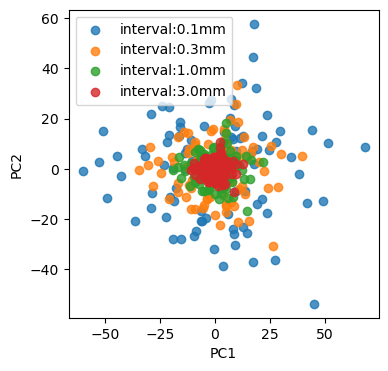

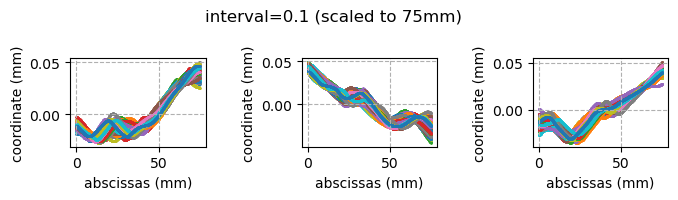

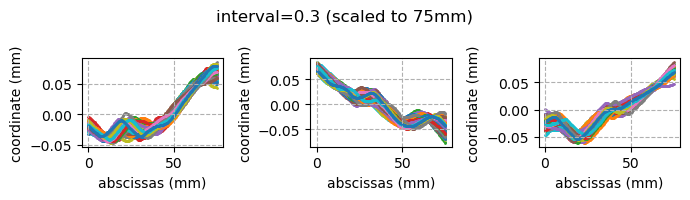

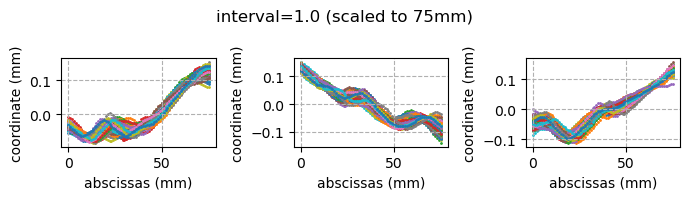

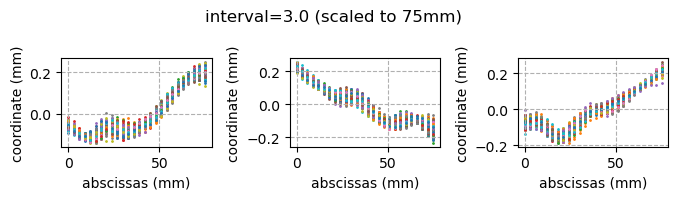

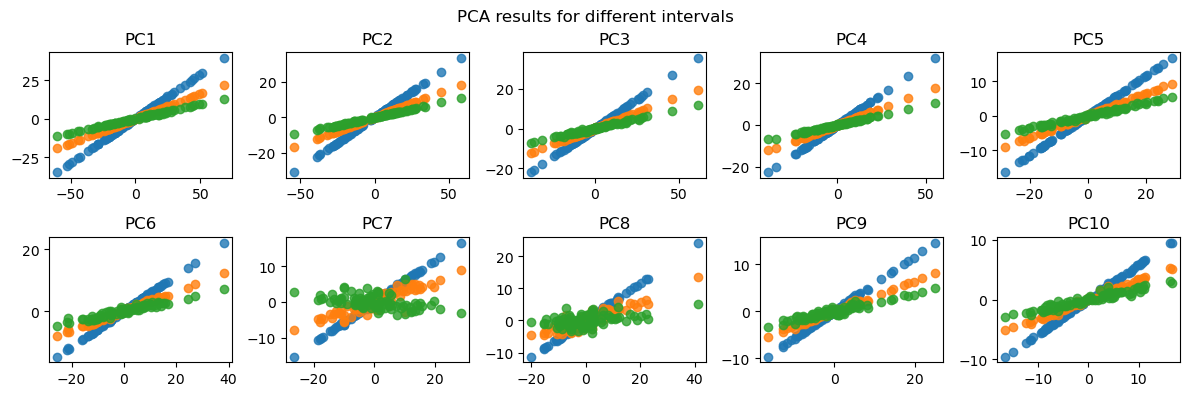

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

n_components = 10
# def resample_centerlines_by_interval(abscissas, original_centerlines, interval):
#     num_curves, num_points = abscissas.shape
    
#     resampled_centerlines = []
#     resampled_abscissas = []

#     for i in range(num_curves):
#         # 获取当前曲线的abscissas和centerlines
#         x = abscissas[i]
#         y = original_centerlines[i]

#         # 确保 x 是单调递增的
#         if not np.all(np.diff(x) > 0):
#             raise ValueError(f"abscissas[{i}] 不是严格单调递增的")

#         # 生成新的采样点
#         new_x = np.arange(x[0], x[-1], interval)
#         resampled_abscissas.append(new_x)

#         # 对 centerlines 进行插值
#         interp_func = interp1d(x, y, axis=0, kind='linear', fill_value='extrapolate')
#         new_y = interp_func(new_x)
#         resampled_centerlines.append(new_y)

#     return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)


def resample_centerlines_by_interval(abscissas, original_centerlines, interval):
    num_curves, num_points = abscissas.shape

    resampled_centerlines = []
    resampled_abscissas = []

    for i in range(num_curves):
        x = abscissas[i]
        y = original_centerlines[i]

        # 确保 x 单调递增
        if not np.all(np.diff(x) > 0):
            x, unique_indices = np.unique(x, return_index=True)
            y = y[unique_indices]

        # 生成新采样点
        new_x = np.arange(x[0], x[-1] + interval, interval)

        # 确保 y 没有 NaN
        y = np.nan_to_num(y, nan=np.nanmean(y, axis=0))

        # 处理 x 只有一个点的情况
        if len(x) < 2:
            new_y = np.full((len(new_x), y.shape[-1]), y[0])
        else:
            interp_func = interp1d(x, y, axis=0, kind='linear', fill_value="extrapolate")
            new_y = interp_func(new_x)

        resampled_abscissas.append(new_x)
        resampled_centerlines.append(new_y)

    return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)




fig1 = plt.figure(figsize=(4,4))
ax1 = fig1.add_subplot(111)

std_pcas = []
std_results = []
interval_var =[0.1,0.3,1.0,3.0]
for interval in interval_var:
    fig2 = plt.figure(figsize=(7,2), dpi=100)
    fig2.suptitle(f"interval={interval} (scaled to 75mm)")
    ax2_1 = fig2.add_subplot(131)
    ax2_2 = fig2.add_subplot(132)
    ax2_3 = fig2.add_subplot(133)
    for  ax in [ax2_1, ax2_2, ax2_3]:
        ax.set_xlabel("abscissas (mm)")
        ax.set_ylabel("coordinate (mm)")
        ax.grid(linestyle="--")
    interpolated_std_abscissas, interpolated_std_centerlines = resample_centerlines_by_interval(resampled_standardized_abscissas, 
                                                                                        resampled_standardized_centerlines, 
                                                                                        interval)

    interpolated_std_centerlines = align_centerlines_procrustes(interpolated_std_centerlines)
    print ("interpolated_std_centerlines.shape:", interpolated_std_centerlines.shape)


    for j in range(len(interpolated_std_centerlines)):
        ax2_1.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 0], marker='o', s=1)
        ax2_2.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 1], marker='o', s=1)
        ax2_3.scatter(interpolated_std_abscissas[j], interpolated_std_centerlines[j, :, 2], marker='o', s=1)
    X = interpolated_std_centerlines.reshape(curve_bs.shape[0], -1)
    fig2.tight_layout(rect=[0, 0, 1, 0.96])
    # 进行标准化 (Z-score)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # 进行 PCA
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(X_scaled)
    std_pcas.append(pca)
    std_results.append(result)
    print ("interval:,",interval,"explained_variance_ratio_:", pca.explained_variance_ratio_)

    ax1.scatter(result[:, 0], result[:, 1], alpha=.8, label="interval:"+str(interval)+"mm")
    
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend()
fig1.show()

std_results = np.array(std_results)
print (std_results.shape)

fig,axes = plt.subplots(2,5,figsize=(12,4))
axes = axes.flatten()
for i in range(n_components):
    for j in range(1,len(std_results)):
        axes[i].scatter(std_results[0][:, i], std_results[j][:, i], label=f"iv={interval_var[j]}",alpha=.8)
        axes[i].set_title(f"PC{i+1}")
        # axes[i].legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("PCA results for different intervals") 
fig.show()

C:\Users\cheno\AppData\Local\Temp\ipykernel_26320\1083378994.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_26320\1083378994.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_26320\1083378994.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\cheno\AppData\Local\Temp\ipykernel_26320\1083378994.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


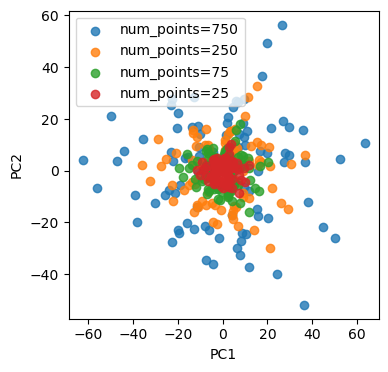

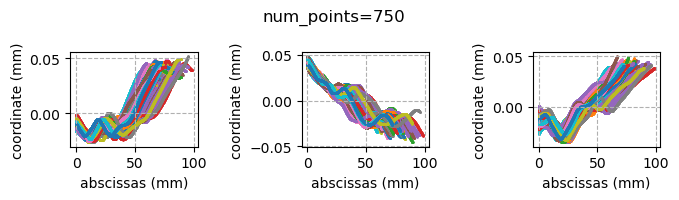

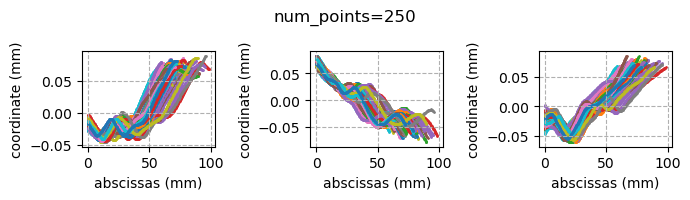

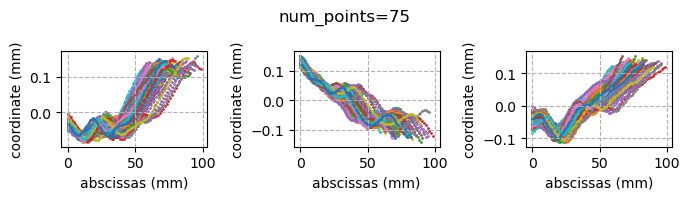

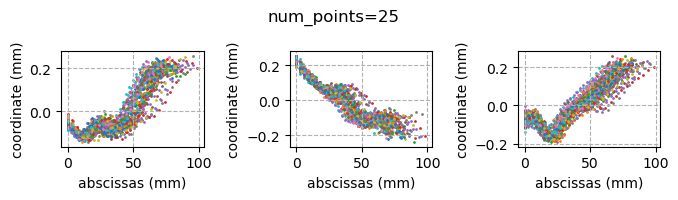

C:\Users\cheno\AppData\Local\Temp\ipykernel_26320\1083378994.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


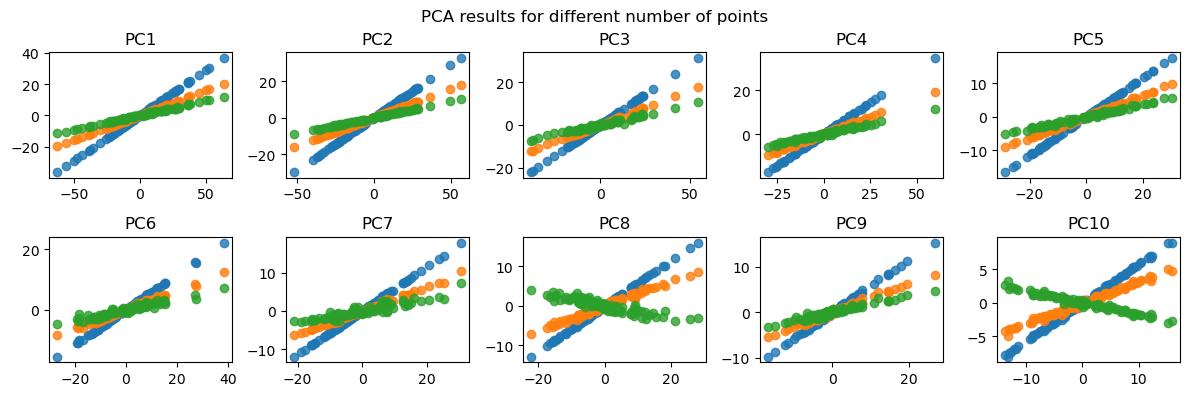

In [142]:
n_components = 10

# def resample_centerlines_by_points(abscissas, original_centerlines, num_points):
#     num_curves, num_original_points = abscissas.shape

#     resampled_centerlines = []
#     resampled_abscissas = []

#     for i in range(num_curves):
#         x = abscissas[i]
#         y = original_centerlines[i]

#         if not np.all(np.diff(x) > 0):
#             raise ValueError(f"abscissas[{i}] 不是严格单调递增的")

#         # 生成新的等间距 abscissas（保持原始范围）
#         new_x = np.linspace(x[0], x[-1], num_points)

#         # 对 centerlines 进行插值
#         curve_func = parameterize_curve(y)
#         new_y = curve_func(np.linspace(0, 1, num_points))  # 按参数化均匀采样

#         resampled_abscissas.append(new_x)
#         resampled_centerlines.append(new_y)

#     return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)

import numpy as np

def resample_centerlines_by_points(abscissas, original_centerlines, num_points):
    num_curves, num_original_points = abscissas.shape

    resampled_centerlines = []
    resampled_abscissas = []

    for i in range(num_curves):
        x = abscissas[i]
        y = original_centerlines[i]

        # 确保 x 单调递增
        if not np.all(np.diff(x) > 0):
            print(f"Warning: abscissas[{i}] 不是严格单调递增，已自动修正。")
            x, unique_indices = np.unique(x, return_index=True)
            y = y[unique_indices]

        # 检查 y 是否包含 NaN
        if np.isnan(y).any():
            print(f"Warning: original_centerlines[{i}] 包含 NaN，已用均值填充。")
            y = np.nan_to_num(y, nan=np.nanmean(y, axis=0))

        # 生成新的等间距 abscissas（保持原始范围）
        new_x = np.linspace(x[0], x[-1], num_points)

        # 对 centerlines 进行插值
        curve_func = parameterize_curve(y)
        new_y = curve_func(np.linspace(0, 1, num_points))  # 按参数化均匀采样

        # 检查 new_y 是否包含 NaN
        if np.isnan(new_y).any():
            print(f"Warning: resampled_centerlines[{i}] 生成了 NaN，已用均值填充。")
            new_y = np.nan_to_num(new_y, nan=np.nanmean(y, axis=0))

        resampled_abscissas.append(new_x)
        resampled_centerlines.append(new_y)

    return np.array(resampled_abscissas, dtype=object), np.array(resampled_centerlines, dtype=object)


original_resampling_data = {}
non_std_results = []

fig_pca = plt.figure(figsize=(4, 4), dpi=100)
ax_pca = fig_pca.add_subplot(111)

points_var =[750, 250, 75, 25]
non_std_pcas = []
for num_points in points_var:
    new_abscissas, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=num_points)
    original_resampling_data[num_points] = (new_abscissas, new_centerlines)
    new_centerlines = align_centerlines_procrustes(new_centerlines)
    X = new_centerlines.reshape(curve_bs.shape[0], -1)
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_components)
    result = pca.fit_transform(X_scaled)
    non_std_pcas.append(pca)
    ax_pca.scatter(result[:, 0], result[:, 1], label=f"num_points={num_points}",alpha=.8)
    non_std_results.append(result)


    fig = plt.figure(figsize=(7, 2), dpi=100)
    fig.suptitle(f"num_points={num_points}")
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    for i in range(len(original_centerlines)):
        ax1.scatter(new_abscissas[i], new_centerlines[i][:, 0], marker='o', s=1)
        ax2.scatter(new_abscissas[i], new_centerlines[i][:, 1], marker='o', s=1)
        ax3.scatter(new_abscissas[i], new_centerlines[i][:, 2], marker='o', s=1)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel("abscissas (mm)")
        ax.set_ylabel("coordinate (mm)")
        ax.grid(linestyle="--")

    fig.tight_layout()
    fig.show()
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")
ax_pca.legend()
plt.show(fig_pca)

fig,axes = plt.subplots(2,5,figsize=(12,4))
axes = axes.flatten()
for i in range(n_components):
    for j in range(1,len(non_std_results)):
        axes[i].scatter(non_std_results[0][:, i], non_std_results[j][:, i], label=f"n_pts={points_var[j]}",alpha=.8)
        axes[i].set_title(f"PC{i+1}")
        # axes[i].legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("PCA results for different number of points")
fig.show()



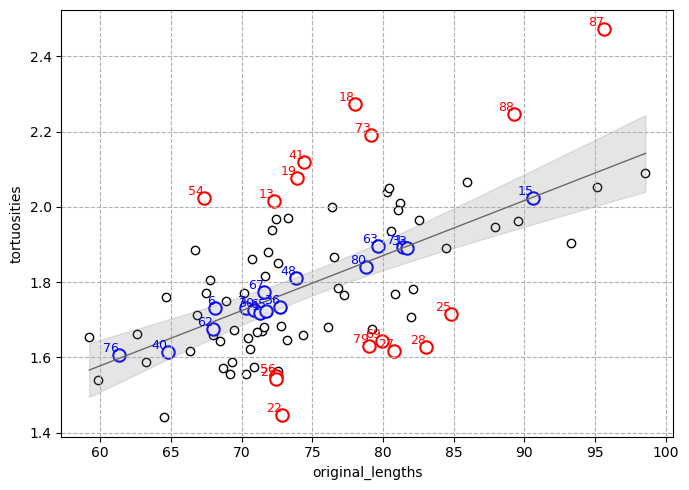

Confidence interval width at x=78.893: 0.073
Indices of points farthest from the line: [56 23 79 69 25 88 13 27 28 19 22 41 73 54 87 18]
Indices of points closest to the line: [71  7 15 33 76 80 30 62  1 65 67 36 63 48 40  6]
71 brava_cut_mirrored\BH0038_ICA_L.vtk
7 brava_cut_mirrored\BG0007_ICA_R.vtk
15 brava_cut_mirrored\BG0011_ICA_R.vtk
33 brava_cut_mirrored\BH0009_ICA_L.vtk
76 brava_cut_mirrored\BI0001_ICA_L.vtk
80 250216tuika\BG0015_L.vtk
30 brava_cut_mirrored\BH0005_ICA_R.vtk
62 brava_cut_mirrored\BH0030_ICA_L.vtk
1 brava_cut_mirrored\BG0001_ICA_R.vtk
65 brava_cut_mirrored\BH0031_ICA_R.vtk
67 brava_cut_mirrored\BH0034_ICA_R.vtk
36 brava_cut_mirrored\BH0010_ICA_R.vtk
63 brava_cut_mirrored\BH0030_ICA_R.vtk
48 brava_cut_mirrored\BH0018_ICA_R.vtk
40 brava_cut_mirrored\BH0013_ICA_R.vtk
6 brava_cut_mirrored\BG0007_ICA_L.vtk


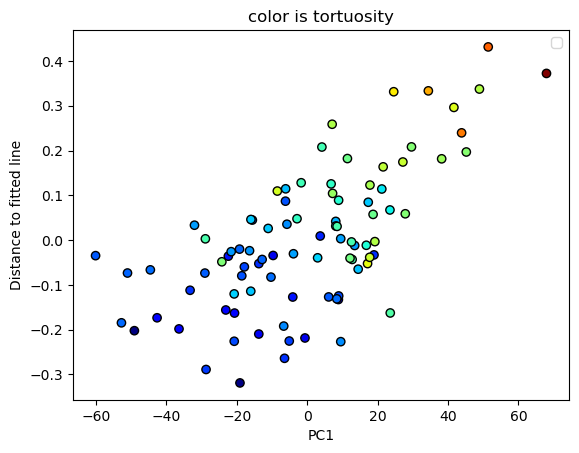

In [143]:
n_highlight = 16  # 需要标出的离散点数量
n_closest = 16  # 需要标出的最近点数量

fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)

# 绘制散点图
sc = ax.scatter(original_lengths, original_tortuosities, color='w', edgecolors='k')
ax.set_ylabel("tortuosities")
ax.set_xlabel("original_lengths")
ax.grid(linestyle="--")

# 线性回归 - statsmodels
X = sm.add_constant(original_lengths)
model = sm.OLS(original_tortuosities, X).fit()

# 获取拟合直线上的 y 值
y_fitted = model.predict(X)

# 计算残差（垂直距离，带符号）
residuals = original_tortuosities - y_fitted

# 找到离直线最远的 n 个点的索引
sorted_indices = np.argsort(np.abs(residuals))[-n_highlight:]

# 标出最远的 n 个点，用红色边框
for idx in sorted_indices:
    ax.scatter(original_lengths[idx], original_tortuosities[idx], facecolor='w', edgecolor='red', s=80, linewidth=1.5)
    ax.text(original_lengths[idx], original_tortuosities[idx], str(idx), fontsize=9, ha='right', va='bottom', color='red')
# 找到离直线最近的 n 个点的索引
closest_indices = np.argsort(np.abs(residuals))[:n_closest]

# 标出最近的 n 个点，用蓝色边框
for idx in closest_indices:
    ax.scatter(original_lengths[idx], original_tortuosities[idx], facecolor='w', edgecolor='blue', s=80, linewidth=1.5)
    ax.text(original_lengths[idx], original_tortuosities[idx], str(idx), fontsize=9, ha='right', va='bottom', color='blue')

# 绘制拟合直线
x_fit = np.linspace(min(original_lengths), max(original_lengths), 100)
X_fit = sm.add_constant(x_fit)
y_fit = model.predict(X_fit)
ax.plot(x_fit, y_fit, color='dimgray', linestyle='-', linewidth=1, label="Fitted Line")

# 获取置信区间 (95%)
pred = model.get_prediction(X_fit)
conf_int = pred.conf_int(alpha=0.05)  # (100, 2)

# 绘制置信区间
ax.fill_between(x_fit, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label="95% Confidence Interval")

plt.tight_layout()
plt.show()

# 计算 x 轴中点处的置信区间宽度
x_mid = np.median(x_fit)
X_mid = np.array([[1, x_mid]])  # 手动组合常数项和 x 值

y_mid_pred = model.predict(X_mid)[0]

# 注意这里也用 X_mid，不要再调用 sm.add_constant()
conf_int_mid = model.get_prediction(X_mid).conf_int(alpha=0.05)[0]
conf_int_width = conf_int_mid[1] - conf_int_mid[0]

print(f"Confidence interval width at x={x_mid:.3f}: {conf_int_width:.3f}")



print("Indices of points farthest from the line:", sorted_indices)
print("Indices of points closest to the line:", closest_indices)
for idx in closest_indices:
    print(idx, files[idx])

def get_distances_to_fit(original_lengths, original_tortuosities):
    # 线性回归 - statsmodels
    X = sm.add_constant(original_lengths)
    model = sm.OLS(original_tortuosities, X).fit()

    # 计算残差（带符号距离）
    y_fitted = model.predict(X)
    residuals = original_tortuosities - y_fitted  # 每个点到拟合直线的垂直距离（正负）

    return residuals

distances = get_distances_to_fit(original_lengths, original_tortuosities)
abs_distances = np.abs(distances)

plt.scatter(std_results[0][:, 0], distances, c=original_tortuosities, cmap='jet', edgecolors='k')
# plt.axhline(y=conf_int_width, color='k', linestyle='--', linewidth=1, label=f"CI Width = {conf_int_width:.3f}")
# plt.axhline(y=2*conf_int_width, color='k', linestyle='--', linewidth=1, label=f"2*CI Width = {2*conf_int_width:.3f}",alpha=0.6)
# plt.axhline(y=3*conf_int_width, color='k', linestyle='--', linewidth=1, label=f"3*CI Width = {3*conf_int_width:.3f}",alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("Distance to fitted line")
plt.title("color is tortuosity")
plt.legend()
plt.show()



C:\Users\cheno\AppData\Local\Temp\ipykernel_26320\4175491723.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(original_tortuosities, g_dist_to_frechet, color = "w",cmap='jet', edgecolors='k')


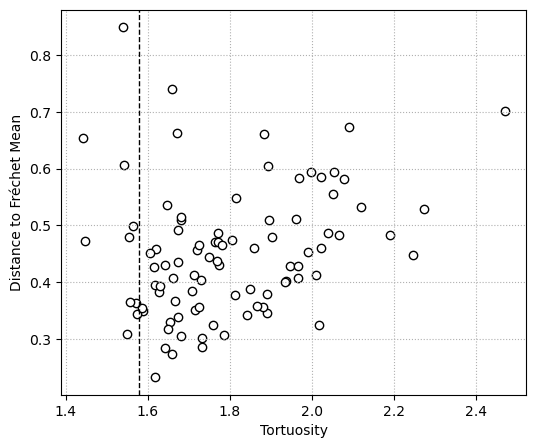

In [144]:
# fig = plt.figure(figsize=(6, 5), dpi=100)
# ax = fig.add_subplot(111)
# ax.scatter(distances, g_dist_to_frechet, c=original_tortuosities, cmap='jet', edgecolors='k')
# ax.set_xlabel("Distance to fitted line")
# ax.set_ylabel("Distance to Fréchet Mean")
# ax.set_title("Color is tortuosity")
# ax.grid(linestyle=":")
# plt.show()


fig = plt.figure(figsize=(6, 5), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(original_tortuosities, g_dist_to_frechet, color = "w",cmap='jet', edgecolors='k')
ax.axvline(mean_estimate_tortuosity, color='k', linestyle='--', linewidth=1, label="Mean Estimate Tortuosity")
ax.set_xlabel("Tortuosity")
ax.set_ylabel("Distance to Fréchet Mean")
# ax.set_title("Color is distance to fitted line")
ax.grid(linestyle=":")
plt.show()

standard PCA explained_variance_ratio_: [0.27247644 0.17419454 0.11545548 0.09166587 0.07059112 0.05390954
 0.04209057 0.04119073 0.02564974 0.02290105 0.01436374 0.01293975
 0.01096728 0.0068833  0.00624485 0.00523726]
PCA transformed shape: (91, 16)


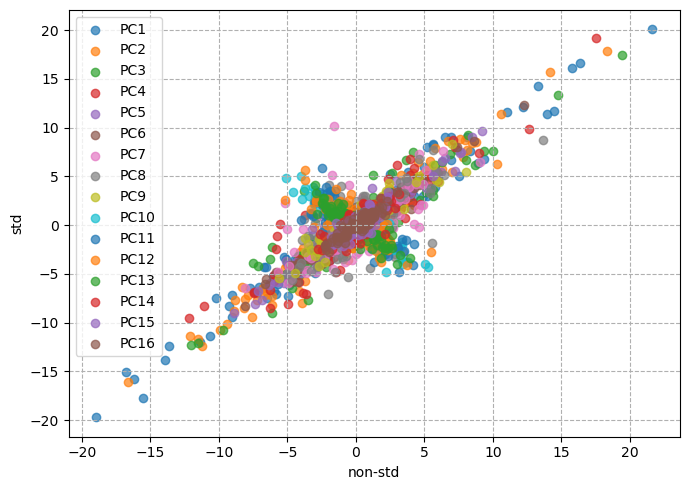

In [145]:
n_components = 16

# 将数据 reshape 为 (79, 3*m)
X = resampled_standardized_centerlines.reshape(curve_bs.shape[0], -1) # 标准化到75mm的centerlines


# 进行标准化 (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 进行 PCA
std_pca = PCA(n_components=n_components)
std_pca_result = std_pca.fit_transform(X_scaled)

print ("standard PCA explained_variance_ratio_:", std_pca.explained_variance_ratio_)
print("PCA transformed shape:", std_pca_result.shape)  # (79, 3)

_, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=75)
new_centerlines = np.array(new_centerlines)
X = new_centerlines.reshape(curve_bs.shape[0], -1)
X_scaled = StandardScaler().fit_transform(X)

non_std_pca = PCA(n_components=n_components)
non_std_pca_result = non_std_pca.fit_transform(X_scaled)


fig = plt.figure(figsize=(7, 5), dpi=100)
ax = fig.add_subplot(111)
for i in range(n_components):
    ax.scatter(std_pca_result[:, i], non_std_pca_result[:, i], label=f"PC{i+1}", alpha=0.7, marker='o')
ax.set_ylabel("std")
ax.set_xlabel("non-std")
ax.grid(linestyle="--")
ax.legend()
plt.tight_layout()    
plt.show()

In [146]:
from itertools import combinations

points_var = [750, 250, 75, 25]
interval_var = [0.1, 0.3, 1.0, 3.0]

original_resampling_data = {}
non_std_pca_results = {}
std_pca_results = {}

# 遍历不同采样设置，计算PCA结果
for num_points, interval in zip(points_var, interval_var):
    print(f"\nProcessing num_points={num_points}, interval={interval}")

    # 非标准化采样
    new_abscissas, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=num_points)
    original_resampling_data[num_points] = (new_abscissas, new_centerlines)

    new_centerlines = align_centerlines_procrustes(new_centerlines)
    non_std_X = new_centerlines.reshape(curve_bs.shape[0], -1)
    non_std_X_scaled = StandardScaler().fit_transform(non_std_X)
    non_std_pca = PCA(n_components=n_components)
    non_std_result = non_std_pca.fit_transform(non_std_X_scaled)
    print ("non_std_PCA ({}) explained_variance_ratio_:{}".format(num_points,non_std_pca.explained_variance_ratio_))

    non_std_pca_results[num_points] = non_std_result

    # 标准化采样
    interpolated_std_abscissas, interpolated_std_centerlines = resample_centerlines_by_interval(
        resampled_standardized_abscissas, resampled_standardized_centerlines, interval
    )

    interpolated_std_centerlines = align_centerlines_procrustes(interpolated_std_centerlines)
    std_X = interpolated_std_centerlines.reshape(curve_bs.shape[0], -1)
    std_X_scaled = StandardScaler().fit_transform(std_X)
    std_pca = PCA(n_components=n_components)
    std_result = std_pca.fit_transform(std_X_scaled)
    print ("std_PCA ({}) explained_variance_ratio_:{}".format(interval,std_pca.explained_variance_ratio_))

    std_pca_results[interval] = std_result

# # 比较 非标准化PCA 内部关系
# print("\n=== Comparing Non-standardized PCA Results ===")
# for (p1, p2) in combinations(points_var, 2):
#     print(f"\nComparing num_points={p1} vs num_points={p2}")
#     analyze_pca_relationship(
#         non_std_pca_results[p1], non_std_pca_results[p2],
#         n_components=n_components,
#         label_1=f"Non-std {p1} points",
#         label_2=f"Non-std {p2} points"
#     )

# # 比较 标准化PCA 内部关系
# print("\n=== Comparing Standardized PCA Results ===")
# for (i1, i2) in combinations(interval_var, 2):
#     print(f"\nComparing interval={i1} vs interval={i2}")
#     analyze_pca_relationship(
#         std_pca_results[i1], std_pca_results[i2],
#         n_components=n_components,
#         label_1=f"Std {i1} interval",
#         label_2=f"Std {i2} interval"
#     )

# # 比较 非标准化PCA vs 标准化PCA 的关系
# print("\n=== Comparing Non-standardized vs Standardized PCA Results ===")
# for num_points, interval in zip(points_var, interval_var):
#     print(f"\nComparing num_points={num_points} vs interval={interval}")
#     analyze_pca_relationship(
#         non_std_pca_results[num_points], std_pca_results[interval],
#         n_components=n_components,
#         label_1=f"Non-std {num_points} points",
#         label_2=f"Std {interval} interval"
#     )



Processing num_points=750, interval=0.1
non_std_PCA (750) explained_variance_ratio_:[0.26267787 0.18689728 0.10826919 0.09104754 0.06944523 0.05164086
 0.04587144 0.04134439 0.02392133 0.02238928 0.01486901 0.01432589
 0.01154066 0.00803782 0.00642176 0.00547051]
std_PCA (0.1) explained_variance_ratio_:[0.27200754 0.17755642 0.11416203 0.09229917 0.07070326 0.05362546
 0.043068   0.04133272 0.02529506 0.02283491 0.01430722 0.01278864
 0.01079324 0.00655648 0.00629568 0.0050615 ]

Processing num_points=250, interval=0.3
non_std_PCA (250) explained_variance_ratio_:[0.26267468 0.18621403 0.10865046 0.0910391  0.06947735 0.0517259
 0.04562755 0.04131984 0.02404291 0.02236756 0.01490737 0.01434331
 0.01154927 0.00807343 0.006423   0.00551582]
std_PCA (0.3) explained_variance_ratio_:[0.27240692 0.17646322 0.11486761 0.0922831  0.0705831  0.05361504
 0.04270431 0.04129023 0.02552375 0.02278569 0.01427756 0.01279965
 0.01080267 0.00664423 0.00626069 0.00509671]

Processing num_points=75, inte

(91, 74, 3)
tPCA explained_variance_ratio_: [0.34583782 0.28009332 0.17818921 0.05153945 0.03175125 0.02313414
 0.02036752 0.01722946 0.01005936 0.0086161 ]


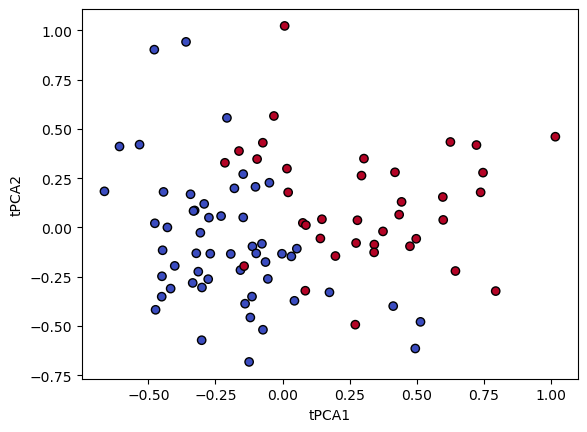

In [147]:
k_sampling_points = 75
print (curve_bs.shape)

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
)

curves_r3.equip_with_metric(SRVMetric)
curves_r3.equip_with_group_action(("rotations", "reparametrizations"))
curves_r3.equip_with_quotient()

tPCA_N_COMPONENTS = 10

tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(curve_bs, base_point=mean_estimate)
tangent_projected_data = tpca.transform(curve_bs)

print ("tPCA explained_variance_ratio_:", tpca.explained_variance_ratio_)

plt.scatter(tangent_projected_data[:, 0], tangent_projected_data[:, 1], c=tortuosity_labels, cmap='coolwarm', edgecolors='k')
plt.xlabel("tPCA1")
plt.ylabel("tPCA2")
plt.show()


# print("\n=== Comparing Non-standardized PCA Results VS tPCA===")
# for p1 in points_var:
#     print(f"\nComparing num_points={p1} vs tPCA")
#     analyze_pca_relationship(
#         non_std_pca_results[p1], tangent_projected_data,
#         n_components=n_components,
#         label_1=f"Non-std {p1} points",
#         label_2=f"tPCA"
#     )

# print("\n=== Comparing Standardized PCA Results VS tPCA===")
# for i1 in interval_var:
#     print(f"\nComparing interval={i1} vs tPCA")
#     analyze_pca_relationship(
#         std_pca_results[i1], tangent_projected_data,
#         n_components=n_components,
#         label_1=f"Std {i1} interval",
    #     label_2=f"tPCA"
    # )

In [148]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr


def summarize_pca_relationships(non_std_pca_results, std_pca_results, tPCA_result, points_var, interval_var, n_components=10, output_csv_path="pca_pairwise_summary.csv"):
    """
    Compare pairwise PCA results (non-std, std, tPCA) and save results as a CSV file.

    Parameters:
    - non_std_pca_results: dict, keys are points_var, values are PCA result arrays
    - std_pca_results: dict, keys are interval_var, values are PCA result arrays
    - tPCA_result: numpy array, tangent PCA result
    - points_var: list of int, e.g., [750, 250, 75, 25]
    - interval_var: list of float, e.g., [0.1, 0.3, 1.0, 3.0]
    - n_components: int, number of components to compare
    - output_csv_path: str, path to save the result as CSV file

    Returns:
    - pd.DataFrame: summary table containing correlations (PC1-PCn), diagonal sum, off-diagonal sum, ratio
    """

    results = []

    def compare_pca_results(pca_result_1, pca_result_2, label_1, label_2):
        # 确保维度一致
        n_components_used = min(n_components, pca_result_1.shape[1], pca_result_2.shape[1])

        # Pearson相关性计算
        corr_results = []
        for i in range(n_components_used):
            corr, _ = pearsonr(pca_result_1[:, i], pca_result_2[:, i])
            corr_results.append(corr)

        # 线性回归计算变换矩阵 W
        model = LinearRegression()
        model.fit(pca_result_1[:, :n_components_used], pca_result_2[:, :n_components_used])
        W = model.coef_

        # 计算对角项和非对角项的绝对值总和及比值
        diag_sum = np.sum(np.abs(np.diag(W)))
        off_diag_sum = np.sum(np.abs(W)) - diag_sum
        off_diag_ratio = off_diag_sum / diag_sum if diag_sum != 0 else np.nan

        # 保存结果
        results.append({
            "Comparison": f"{label_1} vs {label_2}",
            "Diagonal Sum": diag_sum,
            "Off-Diagonal Sum": off_diag_sum,
            "Off-Diagonal/Diagonal Ratio": off_diag_ratio,
            **{f"PC{i + 1} Corr": corr_results[i] for i in range(n_components_used)}
        })

    # 比较 non-std PCA 之间的 pairwise
    for i, p1 in enumerate(points_var):
        for p2 in points_var[i + 1:]:
            compare_pca_results(
                non_std_pca_results[p1], non_std_pca_results[p2],
                label_1=f"Non-std {p1} points", label_2=f"Non-std {p2} points"
            )

    # 比较 std PCA 之间的 pairwise
    for i, i1 in enumerate(interval_var):
        for i2 in interval_var[i + 1:]:
            compare_pca_results(
                std_pca_results[i1], std_pca_results[i2],
                label_1=f"Std {i1} interval", label_2=f"Std {i2} interval"
            )

    # 比较 non-std PCA 和 std PCA 之间的 pairwise
    for p1, i1 in zip(points_var, interval_var):
        compare_pca_results(
            non_std_pca_results[p1], std_pca_results[i1],
            label_1=f"Non-std {p1} points", label_2=f"Std {i1} interval"
        )

    # 比较 non-std PCA 和 tPCA
    for p1 in points_var:
        compare_pca_results(
            non_std_pca_results[p1], tPCA_result,
            label_1=f"Non-std {p1} points", label_2="tPCA"
        )

    # 比较 std PCA 和 tPCA
    for i1 in interval_var:
        compare_pca_results(
            std_pca_results[i1], tPCA_result,
            label_1=f"Std {i1} interval", label_2="tPCA"
        )

    # 转换为 DataFrame
    summary_df = pd.DataFrame(results)

    # 按Comparison列排序，使结果更清晰
    summary_df.sort_values(by="Comparison", inplace=True)

    # 保存为CSV文件
    summary_df.to_csv(output_csv_path, index=False, encoding='utf-8-sig')

    print(f"Summary saved to {output_csv_path}")

    return summary_df


summary_df = summarize_pca_relationships(
    non_std_pca_results, std_pca_results, tangent_projected_data, 
    points_var, interval_var, n_components=10, output_csv_path="pca_pairwise_summary_new.csv"
)


Summary saved to pca_pairwise_summary_new.csv


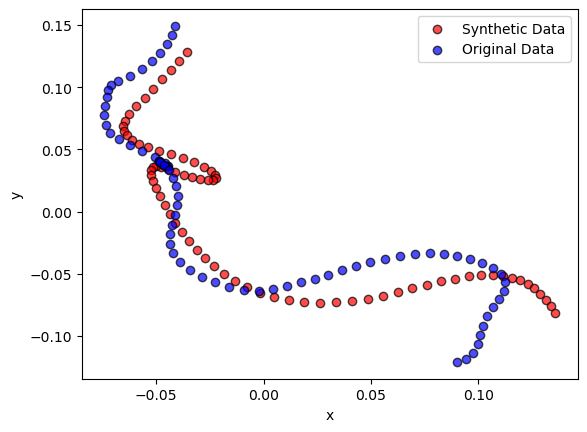

In [149]:
# 预处理数据
scaler = StandardScaler()
std_X = resampled_standardized_centerlines.reshape(curve_bs.shape[0], -1)
std_X_scaled = scaler.fit_transform(std_X)

# PCA 降维
std_PCA = PCA(n_components=10)
std_PCA_features = std_PCA.fit_transform(std_X_scaled)

# 计算 PCA 特征的均值和协方差
std_PCA_features_mean = np.mean(std_PCA_features, axis=0)
std_PCA_features_cov = np.cov(std_PCA_features, rowvar=False)

# 生成 1000 个符合原 PCA 特征分布的样本
synthetic_std_features = np.random.multivariate_normal(std_PCA_features_mean, std_PCA_features_cov * 0.6, size=1000)

# 逆 PCA 变换
synthetic_std_X_scaled = std_PCA.inverse_transform(synthetic_std_features)

# 逆标准化，使用 StandardScaler 的 mean_ 和 scale_
synthetic_std_X = synthetic_std_X_scaled * scaler.scale_ + scaler.mean_

# 还原成 (n, 75, 3) 形状
synthetic_std_centerlines = synthetic_std_X.reshape(1000, 75, 3)

# 可视化第一个生成的曲线与原始曲线对比
plt.scatter(synthetic_std_centerlines[0][:, 0], synthetic_std_centerlines[0][:, 1], label="Synthetic Data", alpha=0.7, c='r', edgecolors='k')
plt.scatter(resampled_standardized_centerlines[0][:, 0], resampled_standardized_centerlines[0][:, 1], label="Original Data", alpha=0.7, c='b', edgecolors='k')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()





synthetic_tortuosity = []
for i in range(len(synthetic_std_centerlines)):
    synthetic_tortuosity.append(calculate_curve_length(synthetic_std_centerlines[i])/np.linalg.norm(synthetic_std_centerlines[i][-1]-synthetic_std_centerlines[i][0]))
synthetic_tortuosity = np.array(synthetic_tortuosity)




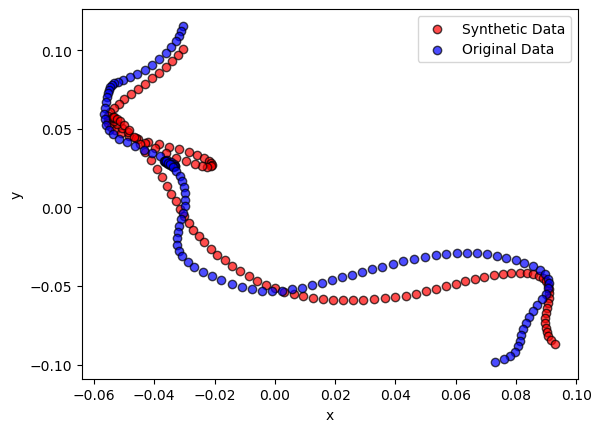

In [150]:
# 预处理数据
scaler = StandardScaler()
non_std_X = original_centerlines.reshape(curve_bs.shape[0], -1)
non_std_X_scaled = scaler.fit_transform(non_std_X)

# PCA 降维
non_std_PCA = PCA(n_components=10)
non_std_PCA_features = non_std_PCA.fit_transform(non_std_X_scaled)

# 计算 PCA 特征的均值和协方差
non_std_PCA_features_mean = np.mean(non_std_PCA_features, axis=0)
non_std_PCA_features_cov = np.cov(non_std_PCA_features, rowvar=False)

# 生成 1000 个符合原 PCA 特征分布的样本
synthetic_non_std_features = np.random.multivariate_normal(non_std_PCA_features_mean, non_std_PCA_features_cov * 1.0, size=1000)

# 逆 PCA 变换
synthetic_non_std_X_scaled = non_std_PCA.inverse_transform(synthetic_non_std_features)

# 逆标准化，使用 StandardScaler 的 mean_ 和 scale_
synthetic_non_std_X = synthetic_non_std_X_scaled * scaler.scale_ + scaler.mean_

# 还原成 (n, 75, 3) 形状
synthetic_non_std_centerlines = synthetic_non_std_X.reshape(1000, 120, 3)

# 可视化第一个生成的曲线与原始曲线对比
plt.scatter(synthetic_non_std_centerlines[0][:, 0], synthetic_non_std_centerlines[0][:, 1], label="Synthetic Data", alpha=0.7, c='r', edgecolors='k')
plt.scatter(original_centerlines[0][:, 0], original_centerlines[0][:, 1], label="Original Data", alpha=0.7, c='b', edgecolors='k')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



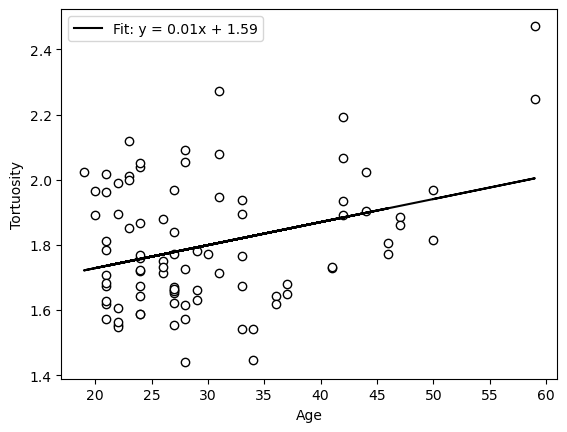

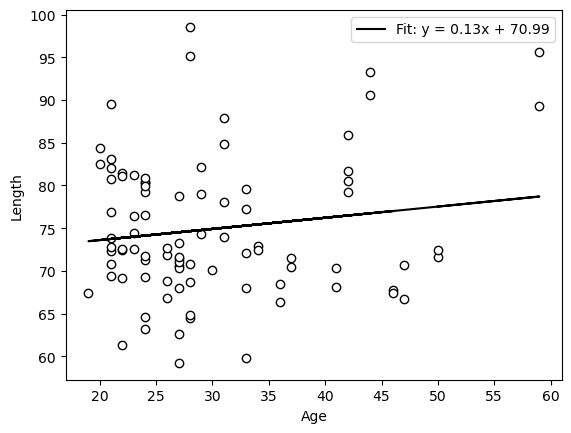

Length vs Age: Pearson r = 0.146, p = 1.723e-01
Tortuosity vs Age: Pearson r = 0.326, p = 1.804e-03


In [151]:
# 获取最大索引，确保创建合适长度的数组
max_index = max(idx for v in merged_result.values() for idx in v['indices'])

# 初始化数组
age_array = [None] * (max_index + 1)
sex_array = [None] * (max_index + 1)

# 填充数组
for person in merged_result.values():
    start, end = person['indices']
    age = person['AGE']
    sex = person['SEX']

    age_array[start] = age
    age_array[end] = age

    sex_numeric = 1 if sex == 'F' else 0
    sex_array[start] = sex_numeric
    sex_array[end] = sex_numeric

# 转为numpy数组
age_array = np.array(age_array)
sex_array = np.array(sex_array)
original_tortuosities = np.array(original_tortuosities)

# 去掉 age_array 中的 None 值，同时确保 tortuosities 和 sex_array 也相应过滤掉
mask = age_array != None
filtered_age = age_array[mask].astype(float)
filtered_tortuosity = original_tortuosities[mask]
filtered_length = original_lengths[mask]
filtered_sex = sex_array[mask]

# 一次函数拟合 (y = ax + b)
coefficients = np.polyfit(filtered_age, filtered_tortuosity, deg=1)
a, b = coefficients

# 绘制散点图，性别作为颜色
plt.scatter(filtered_age, filtered_tortuosity, color='w', edgecolors='k')
plt.plot(filtered_age, a * filtered_age + b, color='k', label=f"Fit: y = {a:.2f}x + {b:.2f}")
plt.xlabel("Age")
plt.ylabel("Tortuosity")
plt.legend()
plt.show()


coefficients = np.polyfit(filtered_age, filtered_length, deg=1)
a, b = coefficients
plt.scatter(filtered_age, filtered_length, color='w', edgecolors='k')
plt.plot(filtered_age, a * filtered_age + b, color='k', label=f"Fit: y = {a:.2f}x + {b:.2f}")
plt.xlabel("Age")
plt.ylabel("Length")
plt.legend()
plt.show()

# 计算 length 与 age 之间的 Pearson 相关系数
r_length_age, p_length_age = pearsonr(filtered_age, filtered_length)
print(f"Length vs Age: Pearson r = {r_length_age:.3f}, p = {p_length_age:.3e}")

# 计算 tortuosity 与 age 之间的 Pearson 相关系数
r_tortuosity_age, p_tortuosity_age = pearsonr(filtered_age, filtered_tortuosity)
print(f"Tortuosity vs Age: Pearson r = {r_tortuosity_age:.3f}, p = {p_tortuosity_age:.3e}")


print (std_scaling_factor) # 127.50148988361944  
print (nonstd_scaling_factor) # 159.65561865714895

In [152]:
def from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, PCA_N_COMPONENTS, discrete_curves_space):
    principal_components = tpca.components_
    # Assuming principal_components has the shape (n_components, n_sampling_points * n_dimensions)
    point_num = len(tangent_base)
    principal_components_reshaped = principal_components.reshape((PCA_N_COMPONENTS, point_num, 3)) # point_num是采样点数
    # Now use exp on each reshaped component
    curves_from_components = [
        discrete_curves_space.metric.exp(tangent_vec=component, base_point=tangent_base)
        for component in principal_components_reshaped
    ]

    reconstructed_curves = []
    for idx in range(len(tangent_projected_data)):
        # This is your feature - a single point in PCA space representing the loadings for the first curve.
        feature = np.array(tangent_projected_data[idx])
        # Reconstruct the tangent vector from the feature.
        # print ("feature:", feature.shape)
        # print ("principal_components_reshaped:", principal_components_reshaped.shape)
        # print ("idx:", idx)
        tangent_vector_reconstructed = sum(feature[i] * principal_components_reshaped[i] for i in range(len(feature)))
        # Map the tangent vector back to the curve space using the exponential map.
        reconstructed_curve = discrete_curves_space.metric.exp(
            tangent_vec=tangent_vector_reconstructed, base_point=tangent_base
        )
        # reconstructed_curve = inverse_srvf(reconstructed_srvf, np.zeros(3))
        # print ("reconstructed_curve length:", measure_length(reconstructed_curve))# length=63
        
        reconstructed_curves.append(reconstructed_curve)
    reconstructed_curves = np.array(reconstructed_curves)
    return reconstructed_curves

interval = 1.0
interpolated_std_abscissas, interpolated_std_centerlines = resample_centerlines_by_interval(resampled_standardized_abscissas, 
                                                                                        resampled_standardized_centerlines, 
                                                                                        interval)
aligned_std_centerlines = align_centerlines_procrustes(interpolated_std_centerlines)
std_X = aligned_std_centerlines.reshape(aligned_std_centerlines.shape[0], -1)
std_X = np.array(std_X, dtype=np.float64)


N_COMPONENTS = 10
# print (std_X)
std_X_mean = np.mean(std_X, axis=0)
std_X_std = np.std(std_X,axis=0)
std_X_scaled = (std_X - std_X_mean) / std_X_std
std_PCA = PCA(n_components=N_COMPONENTS)
std_result = std_PCA.fit_transform(std_X_scaled)
print ("std_PCA explained_variance_ratio_:", std_PCA.explained_variance_ratio_)


num_points = 75
new_abscissas, new_centerlines = resample_centerlines_by_points(abscissas, original_centerlines, num_points=num_points)
new_centerlines = align_centerlines_procrustes(new_centerlines)
nonstd_X = new_centerlines.reshape(new_centerlines.shape[0], -1)
nonstd_X = np.array(nonstd_X, dtype=np.float64)
nonstd_X_mean = np.mean(nonstd_X, axis=0)
nonstd_X_std = np.std(nonstd_X,axis=0)
nonstd_X_scaled = (nonstd_X - nonstd_X_mean) / nonstd_X_std
nonstd_PCA = PCA(n_components=N_COMPONENTS)
nonstd_result = nonstd_PCA.fit_transform(nonstd_X_scaled)
print ("nonstd_PCA explained_variance_ratio_:", nonstd_PCA.explained_variance_ratio_)

discrete_curves_space = curves_r3
reconstructed_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, 
                                                                              tPCA_N_COMPONENTS, 
                                                                              discrete_curves_space)

print ("reconstructed_curves shape:", reconstructed_curves.shape)


# def visualize_pc_variation_vtk(
#     pca_model, original_X, X_mean, X_std, shape, label,
#     pc_index=0, pc_variations=None, scaling_factor=1.0,
#     save_dir="./vtk_output", radius_values=None
# ):
#     """
#     生成 PCA 变化后的曲线，并存为 ASCII VTK 文件，包含曲率和挠率信息。

#     参数:
#     - pca_model: 训练好的 PCA 模型
#     - original_X: 标准化前的原始数据 (flattened)
#     - X_mean: 均值，用于反向标准化
#     - X_std: 标准差，用于反向标准化
#     - shape: 还原后的形状 (n_samples, n_points, 3)
#     - label: 标记当前方法 (e.g., "std_PCA" or "nonstd_PCA")
#     - pc_index: 选择调整的 PCA 组件 (默认 0，即 PC1)
#     - pc_variations: 调整 PCA 组件的变动因子列表 (默认 [-2, -1, 0, 1, 2])
#     - scaling_factor: 缩放输出曲线的大小 (默认 1.0)
#     - save_dir: VTK 文件存储的目录
#     - radius_values: 半径信息 (list 或 None)，如果提供，将存入 VTK 文件
#     """

#     # 确保存储目录存在
#     os.makedirs(save_dir, exist_ok=True)

#     # 默认 PC 变动范围
#     if pc_variations is None:
#         pc_variations = [-2, -1, 0, 1, 2]

#     # 获取 PCA 结果
#     X_pca = pca_model.transform((original_X - X_mean) / X_std)

#     for factor in pc_variations:
#         modified_X_pca = X_pca.copy()
#         modified_X_pca[:, pc_index] += factor * np.std(X_pca[:, pc_index])  # 调整选定 PC

#         # 逆变换回标准化后的 X
#         reconstructed_X_scaled = pca_model.inverse_transform(modified_X_pca)

#         # 反向标准化
#         reconstructed_X = reconstructed_X_scaled * X_std + X_mean

#         # 变回 (n_samples, n_points, 3) 形式
#         modified_curve = reconstructed_X.reshape(shape)[0]  # 取第一条曲线
#         modified_curve *= scaling_factor  # 应用缩放

#         # 计算曲率和挠率
#         curvature, torsion = compute_curvature_and_torsion(modified_curve)

#         # 生成 VTK 文件路径
#         save_path = os.path.join(save_dir, f"{label}_PC{pc_index+1}_{factor}.vtk")

#         # 组织 VTK 额外属性数据
#         scalarAttributes = []
#         if radius_values is not None:
#             scalarAttributes.append(["MaximumInscribedSphereRadius", "float", radius_values])
#         scalarAttributes.append(["Curvature", "float", curvature])
#         scalarAttributes.append(["Torsion", "float", torsion])

#         # 生成 VTK 文件
#         makeVtkFile(save_path, modified_curve, scalarAttributes)

#         print(f"Saved: {save_path}")
def visualize_pc_variation_vtk(
    pca_model, original_X, X_mean, X_std, shape, label,
    pc_index=0, pc_variations=None, scaling_factor=1.0,
    save_dir="./vtk_output", radius_values=None
):
    """
    生成 PCA 变化后的曲线，并存为 ASCII VTK 文件，包含曲率和挠率信息。

    参数:
    - pca_model: 训练好的 PCA 模型
    - original_X: 标准化前的原始数据 (flattened)
    - X_mean: 均值，用于反向标准化
    - X_std: 标准差，用于反向标准化
    - shape: 还原后的形状 (n_samples, n_points, 3)
    - label: 标记当前方法 (e.g., "std_PCA" or "nonstd_PCA")
    - pc_index: 选择调整的 PCA 组件 (默认 0，即 PC1)
    - pc_variations: 调整 PCA 组件的变动因子列表 (默认 [-2, -1, 0, 1, 2])
    - scaling_factor: 缩放输出曲线的大小 (默认 1.0)
    - save_dir: VTK 文件存储的目录
    - radius_values: 半径信息 (list 或 None)，如果提供，将存入 VTK 文件
    """

    # 确保存储目录存在
    os.makedirs(save_dir, exist_ok=True)

    # 默认 PC 变动范围
    if pc_variations is None:
        pc_variations = [-2, -1, 0, 1, 2]

    # 获取 PCA 结果
    X_pca = pca_model.transform((original_X - X_mean) / X_std)

    for factor in pc_variations:
        modified_X_pca = X_pca.copy()
        modified_X_pca[:, pc_index] += factor * np.std(X_pca[:, pc_index])  # 调整选定 PC

        # 逆变换回标准化后的 X
        reconstructed_X_scaled = pca_model.inverse_transform(modified_X_pca)

        # 反向标准化
        reconstructed_X = reconstructed_X_scaled * X_std + X_mean

        # 变回 (n_samples, n_points, 3) 形式
        reconstructed_curves = reconstructed_X.reshape(shape)

        # Step 1: Procrustes 对齐
        aligned_curves = align_centerlines_procrustes(reconstructed_curves)

        # Step 2: 计算均值曲线
        mean_aligned_curve = np.mean(aligned_curves, axis=0)  # 计算均值曲线
        mean_aligned_curve *= scaling_factor  # 应用缩放

        # Step 3: 计算曲率和挠率
        curvature, torsion = compute_curvature_and_torsion(mean_aligned_curve)

        # 生成 VTK 文件路径
        save_path = os.path.join(save_dir, f"{label}_PC{pc_index+1}_{factor}.vtk")

        # 组织 VTK 额外属性数据
        scalarAttributes = []
        if radius_values is not None:
            scalarAttributes.append(["MaximumInscribedSphereRadius", "float", radius_values])
        scalarAttributes.append(["Curvature", "float", curvature])
        scalarAttributes.append(["Torsion", "float", torsion])

        # 生成 VTK 文件
        makeVtkFile(save_path, mean_aligned_curve, scalarAttributes)

        print(f"Saved: {save_path}")


std_radius = np.linspace(1.2, 2, aligned_std_centerlines.shape[1])
non_std_radius = np.linspace(1.2, 2, new_centerlines.shape[1])

for i in range(N_COMPONENTS):
    # 生成标准化 PCA 的 PC1 变化 VTK
    visualize_pc_variation_vtk(
        std_PCA, std_X, std_X_mean, std_X_std, aligned_std_centerlines.shape,
        label="std_PCA", pc_index=i, pc_variations=[-2, -1, 0, 1, 2], scaling_factor=std_scaling_factor,
        radius_values=std_radius
    )

    # 生成非标准化 PCA 的 PC1 变化 VTK
    visualize_pc_variation_vtk(
        nonstd_PCA, nonstd_X, nonstd_X_mean, nonstd_X_std, new_centerlines.shape,
        label="nonstd_PCA", pc_index=i, pc_variations=[-2, -1, 0, 1, 2], scaling_factor=nonstd_scaling_factor,
        radius_values=non_std_radius
    )



std_PCA explained_variance_ratio_: [0.2727439  0.17423291 0.1161156  0.09189523 0.07063236 0.05398682
 0.04203251 0.04115226 0.02576622 0.02280648]
nonstd_PCA explained_variance_ratio_: [0.26266353 0.18379191 0.11000881 0.09094992 0.06950924 0.05211941
 0.04476178 0.04115528 0.0245465  0.02227434]
reconstructed_curves shape: (91, 74, 3)
Saved: ./vtk_output\std_PCA_PC1_-2.vtk
Saved: ./vtk_output\std_PCA_PC1_-1.vtk
Saved: ./vtk_output\std_PCA_PC1_0.vtk
Saved: ./vtk_output\std_PCA_PC1_1.vtk
Saved: ./vtk_output\std_PCA_PC1_2.vtk
Saved: ./vtk_output\nonstd_PCA_PC1_-2.vtk
Saved: ./vtk_output\nonstd_PCA_PC1_-1.vtk
Saved: ./vtk_output\nonstd_PCA_PC1_0.vtk
Saved: ./vtk_output\nonstd_PCA_PC1_1.vtk
Saved: ./vtk_output\nonstd_PCA_PC1_2.vtk
Saved: ./vtk_output\std_PCA_PC2_-2.vtk
Saved: ./vtk_output\std_PCA_PC2_-1.vtk
Saved: ./vtk_output\std_PCA_PC2_0.vtk
Saved: ./vtk_output\std_PCA_PC2_1.vtk
Saved: ./vtk_output\std_PCA_PC2_2.vtk
Saved: ./vtk_output\nonstd_PCA_PC2_-2.vtk
Saved: ./vtk_output\nonstd_P

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, 

Saved: ./vtk_output\std_PCA_PC3_-2.vtk
Saved: ./vtk_output\std_PCA_PC3_-1.vtk
Saved: ./vtk_output\std_PCA_PC3_0.vtk
Saved: ./vtk_output\std_PCA_PC3_1.vtk
Saved: ./vtk_output\std_PCA_PC3_2.vtk
Saved: ./vtk_output\nonstd_PCA_PC3_-2.vtk
Saved: ./vtk_output\nonstd_PCA_PC3_-1.vtk
Saved: ./vtk_output\nonstd_PCA_PC3_0.vtk
Saved: ./vtk_output\nonstd_PCA_PC3_1.vtk
Saved: ./vtk_output\nonstd_PCA_PC3_2.vtk
Saved: ./vtk_output\std_PCA_PC4_-2.vtk
Saved: ./vtk_output\std_PCA_PC4_-1.vtk
Saved: ./vtk_output\std_PCA_PC4_0.vtk
Saved: ./vtk_output\std_PCA_PC4_1.vtk
Saved: ./vtk_output\std_PCA_PC4_2.vtk
Saved: ./vtk_output\nonstd_PCA_PC4_-2.vtk
Saved: ./vtk_output\nonstd_PCA_PC4_-1.vtk
Saved: ./vtk_output\nonstd_PCA_PC4_0.vtk
Saved: ./vtk_output\nonstd_PCA_PC4_1.vtk
Saved: ./vtk_output\nonstd_PCA_PC4_2.vtk
Saved: ./vtk_output\std_PCA_PC5_-2.vtk
Saved: ./vtk_output\std_PCA_PC5_-1.vtk
Saved: ./vtk_output\std_PCA_PC5_0.vtk
Saved: ./vtk_output\std_PCA_PC5_1.vtk
Saved: ./vtk_output\std_PCA_PC5_2.vtk
Saved: ./v

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, 

Saved: ./vtk_output\nonstd_PCA_PC5_2.vtk
Saved: ./vtk_output\std_PCA_PC6_-2.vtk
Saved: ./vtk_output\std_PCA_PC6_-1.vtk
Saved: ./vtk_output\std_PCA_PC6_0.vtk
Saved: ./vtk_output\std_PCA_PC6_1.vtk
Saved: ./vtk_output\std_PCA_PC6_2.vtk
Saved: ./vtk_output\nonstd_PCA_PC6_-2.vtk
Saved: ./vtk_output\nonstd_PCA_PC6_-1.vtk
Saved: ./vtk_output\nonstd_PCA_PC6_0.vtk
Saved: ./vtk_output\nonstd_PCA_PC6_1.vtk
Saved: ./vtk_output\nonstd_PCA_PC6_2.vtk
Saved: ./vtk_output\std_PCA_PC7_-2.vtk
Saved: ./vtk_output\std_PCA_PC7_-1.vtk
Saved: ./vtk_output\std_PCA_PC7_0.vtk
Saved: ./vtk_output\std_PCA_PC7_1.vtk
Saved: ./vtk_output\std_PCA_PC7_2.vtk
Saved: ./vtk_output\nonstd_PCA_PC7_-2.vtk
Saved: ./vtk_output\nonstd_PCA_PC7_-1.vtk
Saved: ./vtk_output\nonstd_PCA_PC7_0.vtk
Saved: ./vtk_output\nonstd_PCA_PC7_1.vtk
Saved: ./vtk_output\nonstd_PCA_PC7_2.vtk
Saved: ./vtk_output\std_PCA_PC8_-2.vtk
Saved: ./vtk_output\std_PCA_PC8_-1.vtk
Saved: ./vtk_output\std_PCA_PC8_0.vtk
Saved: ./vtk_output\std_PCA_PC8_1.vtk
Saved: 

d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, 

In [153]:
def visualize_tpca_variation_vtk(
    tpca_model, tangent_projected_data, tangent_base, shape, label,
    pc_index=0, pc_variations=None, save_dir="./vtk_output", radius_values=None
):
    """
    生成 tPCA 变化后的曲线，并存为 ASCII VTK 文件，包含曲率和挠率信息。

    参数:
    - tpca_model: 训练好的 tPCA 模型
    - tangent_projected_data: tPCA 空间中的数据
    - tangent_base: 指数映射的基点
    - shape: 还原后的形状 (n_samples, n_points, 3)
    - label: 标记当前方法 (e.g., "tPCA")
    - pc_index: 选择调整的 PCA 组件 (默认 0，即 PC1)
    - pc_variations: 调整 PCA 组件的变动因子列表 (默认 [-2, -1, 0, 1, 2])
    - save_dir: VTK 文件存储的目录
    - radius_values: 半径信息 (list 或 None)，如果提供，将存入 VTK 文件
    """

    # 确保存储目录存在
    os.makedirs(save_dir, exist_ok=True)

    # 默认 PC 变动范围
    if pc_variations is None:
        pc_variations = [-2, -1, 0, 1, 2]

    # 计算 tPCA 该主成分的标准差
    tPCA_std = np.std(tangent_projected_data[:, pc_index])

    for factor in pc_variations:
        modified_tangent_data = tangent_projected_data.copy()
        modified_tangent_data[:, pc_index] += factor * tPCA_std  # 只修改主成分系数，不修改其他维度

        # 逆变换回曲线空间
        reconstructed_curves = from_tangentPCA_feature_to_curves(
            tpca_model, tangent_base, modified_tangent_data, tPCA_N_COMPONENTS, discrete_curves_space
        )

        # Step 1: Procrustes 对齐
        aligned_curves = align_centerlines_procrustes(reconstructed_curves)

        # Step 2: 计算缩放因子并恢复长度
        def compute_curve_length(curve):
            return np.sum(np.linalg.norm(np.diff(curve, axis=0), axis=1))

        target_length = 75
        scaled_curves = []
        for curve in aligned_curves:
            curve_length = compute_curve_length(curve)
            scaling_factor = target_length / curve_length  # 计算缩放因子
            scaled_curve = curve * scaling_factor  # 按比例缩放
            scaled_curves.append(scaled_curve)

        scaled_curves = np.array(scaled_curves)

        # Step 3: 计算曲率和挠率（仅计算平均曲线）
        mean_scaled_curve = np.mean(scaled_curves, axis=0)  # 计算均值曲线
        curvature, torsion = compute_curvature_and_torsion(mean_scaled_curve)

        # 生成 VTK 文件（每个 factor 只输出 1 次）
        save_path = os.path.join(save_dir, f"{label}_PC{pc_index+1}_{factor}.vtk")
        scalarAttributes = [["Curvature", "float", curvature], ["Torsion", "float", torsion]]
        makeVtkFile(save_path, mean_scaled_curve, scalarAttributes)

        print(f"Saved: {save_path}")

tPCA_radius = np.linspace(1.2, 2, tangent_projected_data.shape[1])

for i in range(tPCA_N_COMPONENTS):
    visualize_tpca_variation_vtk(
        tpca, tangent_projected_data, tangent_base, tangent_projected_data.shape,
        label="tPCA", pc_index=i, pc_variations=[-2, -1, 0, 1, 2], save_dir="./vtk_output",
        radius_values=tPCA_radius
    )




Saved: ./vtk_output\tPCA_PC1_-2.vtk
Saved: ./vtk_output\tPCA_PC1_-1.vtk
Saved: ./vtk_output\tPCA_PC1_0.vtk
Saved: ./vtk_output\tPCA_PC1_1.vtk
Saved: ./vtk_output\tPCA_PC1_2.vtk
Saved: ./vtk_output\tPCA_PC2_-2.vtk
Saved: ./vtk_output\tPCA_PC2_-1.vtk
Saved: ./vtk_output\tPCA_PC2_0.vtk
Saved: ./vtk_output\tPCA_PC2_1.vtk
Saved: ./vtk_output\tPCA_PC2_2.vtk
Saved: ./vtk_output\tPCA_PC3_-2.vtk
Saved: ./vtk_output\tPCA_PC3_-1.vtk
Saved: ./vtk_output\tPCA_PC3_0.vtk
Saved: ./vtk_output\tPCA_PC3_1.vtk
Saved: ./vtk_output\tPCA_PC3_2.vtk
Saved: ./vtk_output\tPCA_PC4_-2.vtk
Saved: ./vtk_output\tPCA_PC4_-1.vtk
Saved: ./vtk_output\tPCA_PC4_0.vtk
Saved: ./vtk_output\tPCA_PC4_1.vtk
Saved: ./vtk_output\tPCA_PC4_2.vtk
Saved: ./vtk_output\tPCA_PC5_-2.vtk
Saved: ./vtk_output\tPCA_PC5_-1.vtk
Saved: ./vtk_output\tPCA_PC5_0.vtk
Saved: ./vtk_output\tPCA_PC5_1.vtk
Saved: ./vtk_output\tPCA_PC5_2.vtk
Saved: ./vtk_output\tPCA_PC6_-2.vtk
Saved: ./vtk_output\tPCA_PC6_-1.vtk
Saved: ./vtk_output\tPCA_PC6_0.vtk
Saved: .

c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


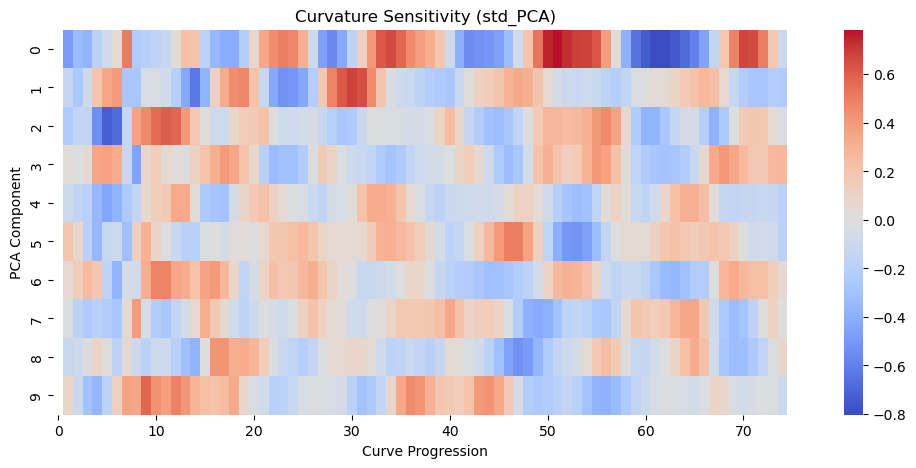

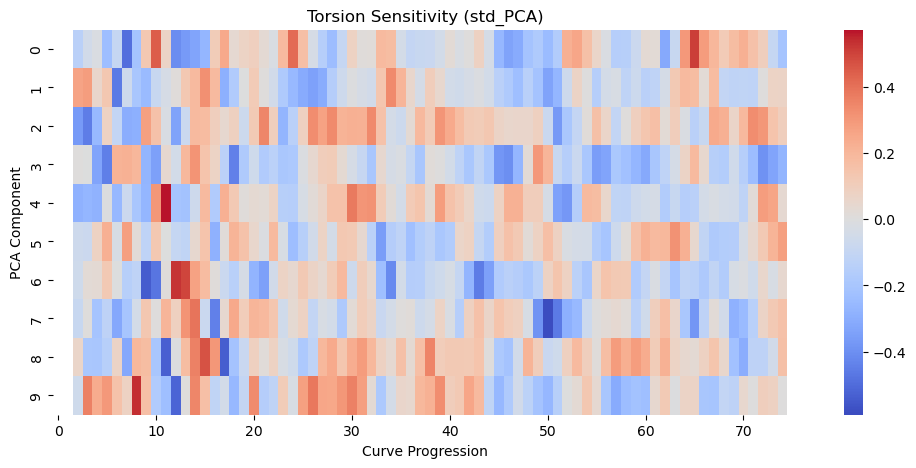

c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


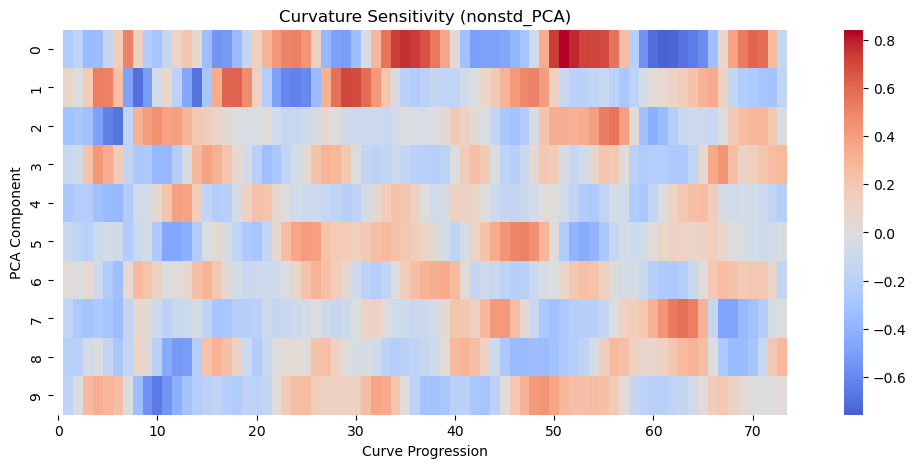

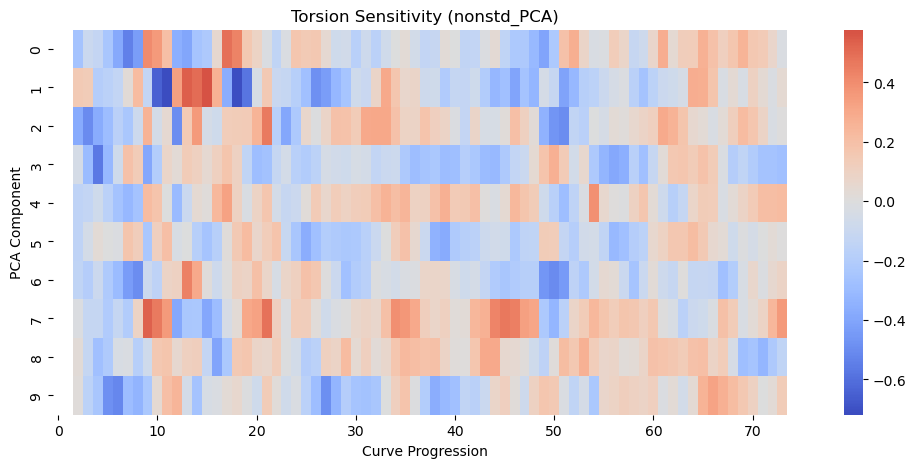

In [161]:
def generate_synthetic_curves(pca_model, original_pca_result, X_mean, X_std, shape, scaling_factor, num_samples=100):
    """
    生成 synthetic 曲线，并计算对应的 PCA 系数、曲率和挠率。

    参数：
    - pca_model: 训练好的 PCA 模型
    - original_pca_result: 真实数据的 PCA 结果 (用于设定 synthetic 数据分布)
    - X_mean: 原始数据的均值
    - X_std: 原始数据的标准差
    - shape: 还原后的形状 (n_samples, n_points, 3)
    - scaling_factor: 缩放因子
    - num_samples: 生成的 synthetic 曲线数量 (默认 100)

    返回：
    - synthetic_curves: 生成的 synthetic 曲线 (num_samples, n_points, 3)
    - synthetic_pca_coeffs: 生成的 PCA 系数 (num_samples, num_pca_components)
    - synthetic_curvature: 生成曲线的曲率 (num_samples, n_points)
    - synthetic_torsion: 生成曲线的挠率 (num_samples, n_points)
    """

    num_pca_components = original_pca_result.shape[1]

    # 生成 synthetic PCA 系数 (高斯分布，与真实 PCA 系数一致)
    pca_mean = np.mean(original_pca_result, axis=0)
    pca_std = np.std(original_pca_result, axis=0)
    synthetic_pca_coeffs = np.random.normal(loc=pca_mean, scale=pca_std, size=(num_samples, num_pca_components))

    # 逆变换回标准化后的 X
    synthetic_X_scaled = pca_model.inverse_transform(synthetic_pca_coeffs)

    # 反标准化
    synthetic_X = synthetic_X_scaled * X_std + X_mean

    # 变回 (num_samples, n_points, 3) 形式，并进行缩放
    synthetic_curves = synthetic_X.reshape((num_samples,) + shape[1:])
    synthetic_curves *= scaling_factor

    # 计算曲率和挠率
    synthetic_curvature = []
    synthetic_torsion = []

    for curve in synthetic_curves:
        curvature, torsion = compute_curvature_and_torsion(curve)
        synthetic_curvature.append(curvature)
        synthetic_torsion.append(torsion)

    synthetic_curvature = np.array(synthetic_curvature)
    synthetic_torsion = np.array(synthetic_torsion)

    return synthetic_curves, synthetic_pca_coeffs, synthetic_curvature, synthetic_torsion

# 生成标准化 PCA 的 synthetic 曲线
std_synthetic_curves, std_synthetic_pca_coeffs, std_synthetic_curvature, std_synthetic_torsion = generate_synthetic_curves(
    std_PCA, std_result, std_X_mean, std_X_std, aligned_std_centerlines.shape, std_scaling_factor, num_samples=100
)

# 生成非标准化 PCA 的 synthetic 曲线
nonstd_synthetic_curves, nonstd_synthetic_pca_coeffs, nonstd_synthetic_curvature, nonstd_synthetic_torsion = generate_synthetic_curves(
    nonstd_PCA, nonstd_result, nonstd_X_mean, nonstd_X_std, new_centerlines.shape, nonstd_scaling_factor, num_samples=100
)


def analyze_and_visualize_sensitivity(synthetic_pca_coeffs, synthetic_curvature, synthetic_torsion, label):
    """
    计算并可视化 PCA 组件对曲率和挠率的敏感性。

    参数:
    - synthetic_pca_coeffs: 形状 (num_samples, num_pca_components)，PCA 系数
    - synthetic_curvature: 形状 (num_samples, num_points)，曲率数据
    - synthetic_torsion: 形状 (num_samples, num_points)，挠率数据
    - label: 标记当前方法 (e.g., "std_PCA" 或 "nonstd_PCA")
    """

    num_pca_components = synthetic_pca_coeffs.shape[1]
    num_points = synthetic_curvature.shape[1]

    curvature_sensitivity = np.zeros((num_pca_components, num_points))
    torsion_sensitivity = np.zeros((num_pca_components, num_points))

    for pc_idx in range(num_pca_components):
        for point_idx in range(num_points):
            curvature_sensitivity[pc_idx, point_idx], _ = pearsonr(synthetic_pca_coeffs[:, pc_idx], synthetic_curvature[:, point_idx])
            torsion_sensitivity[pc_idx, point_idx], _ = pearsonr(synthetic_pca_coeffs[:, pc_idx], synthetic_torsion[:, point_idx])

    # 可视化曲率敏感性
    plt.figure(figsize=(12, 5))
    sns.heatmap(curvature_sensitivity, cmap="coolwarm", center=0, annot=False, xticklabels=10, yticklabels=1)
    plt.xlabel("Curve Progression")
    plt.ylabel("PCA Component")
    plt.title(f"Curvature Sensitivity ({label})")
    plt.show()

    # 可视化挠率敏感性
    plt.figure(figsize=(12, 5))
    sns.heatmap(torsion_sensitivity, cmap="coolwarm", center=0, annot=False, xticklabels=10, yticklabels=1)
    plt.xlabel("Curve Progression")
    plt.ylabel("PCA Component")
    plt.title(f"Torsion Sensitivity ({label})")
    plt.show()

# 可视化标准化 PCA 的敏感性分析
analyze_and_visualize_sensitivity(std_synthetic_pca_coeffs, std_synthetic_curvature, std_synthetic_torsion, label="std_PCA")

# 可视化非标准化 PCA 的敏感性分析
analyze_and_visualize_sensitivity(nonstd_synthetic_pca_coeffs, nonstd_synthetic_curvature, nonstd_synthetic_torsion, label="nonstd_PCA")


d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


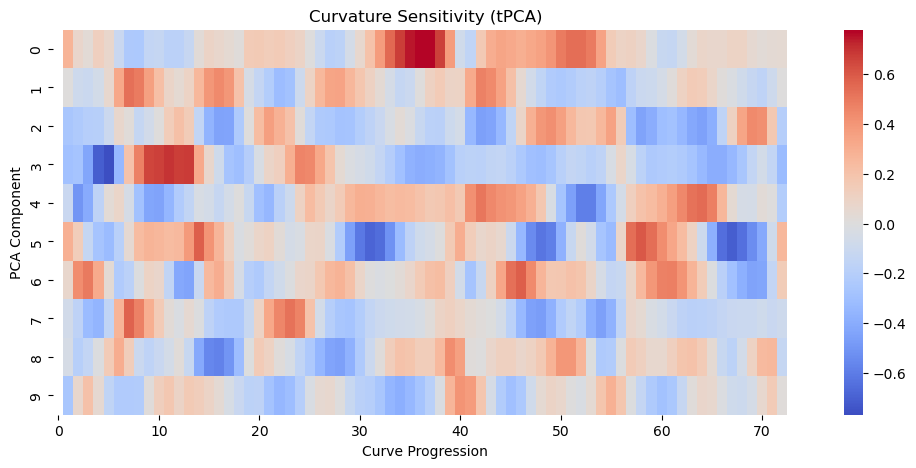

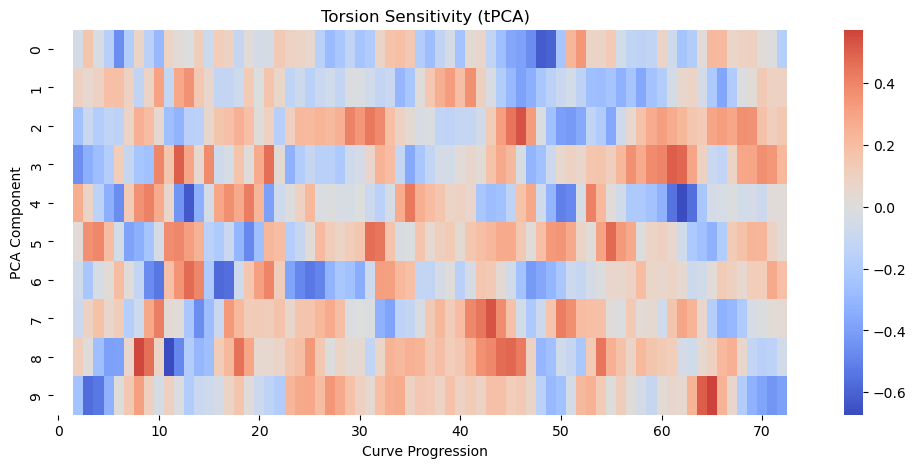

In [162]:




def generate_synthetic_tpca_curves(tpca_model, tangent_projected_data, tangent_base, num_samples=100):
    """
    生成 tPCA 的 synthetic 曲线，并计算对应的 tPCA 系数、曲率和挠率。

    参数：
    - tpca_model: 训练好的 tPCA 模型
    - tangent_projected_data: 真实数据的 tPCA 结果 (用于设定 synthetic 数据分布)
    - tangent_base: 指数映射的基点
    - num_samples: 生成的 synthetic 曲线数量 (默认 100)

    返回：
    - synthetic_curves: 生成的 synthetic 曲线 (num_samples, n_points, 3)
    - synthetic_tpca_coeffs: 生成的 tPCA 系数 (num_samples, num_pca_components)
    - synthetic_curvature: 生成曲线的曲率 (num_samples, n_points)
    - synthetic_torsion: 生成曲线的挠率 (num_samples, n_points)
    """

    num_pca_components = tangent_projected_data.shape[1]

    # 生成 synthetic tPCA 系数（高斯分布，与真实 tPCA 系数一致）
    tpca_mean = np.mean(tangent_projected_data, axis=0)
    tpca_std = np.std(tangent_projected_data, axis=0)
    synthetic_tpca_coeffs = np.random.normal(loc=tpca_mean, scale=tpca_std, size=(num_samples, num_pca_components))

    # 逆变换回曲线空间
    synthetic_curves = from_tangentPCA_feature_to_curves(
        tpca_model, tangent_base, synthetic_tpca_coeffs, tPCA_N_COMPONENTS, discrete_curves_space
    )

    # Step 1: Procrustes 对齐
    aligned_curves = align_centerlines_procrustes(synthetic_curves)

    # Step 2: 计算缩放因子并恢复长度
    def compute_curve_length(curve):
        return np.sum(np.linalg.norm(np.diff(curve, axis=0), axis=1))

    target_length = 75
    scaled_curves = []
    for curve in aligned_curves:
        curve_length = compute_curve_length(curve)
        scaling_factor = target_length / curve_length  # 计算缩放因子
        scaled_curve = curve * scaling_factor  # 按比例缩放
        scaled_curves.append(scaled_curve)

    scaled_curves = np.array(scaled_curves)

    # Step 3: 计算曲率和挠率
    synthetic_curvature = []
    synthetic_torsion = []

    for curve in scaled_curves:
        curvature, torsion = compute_curvature_and_torsion(curve)
        synthetic_curvature.append(curvature)
        synthetic_torsion.append(torsion)

    synthetic_curvature = np.array(synthetic_curvature)
    synthetic_torsion = np.array(synthetic_torsion)

    return scaled_curves, synthetic_tpca_coeffs, synthetic_curvature, synthetic_torsion

tPCA_synthetic_curves, tPCA_synthetic_tpca_coeffs, tPCA_synthetic_curvature, tPCA_synthetic_torsion = generate_synthetic_tpca_curves(
    tpca, tangent_projected_data, tangent_base, num_samples=100
)

analyze_and_visualize_sensitivity(
    tPCA_synthetic_tpca_coeffs, tPCA_synthetic_curvature, tPCA_synthetic_torsion, label="tPCA"
)


c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


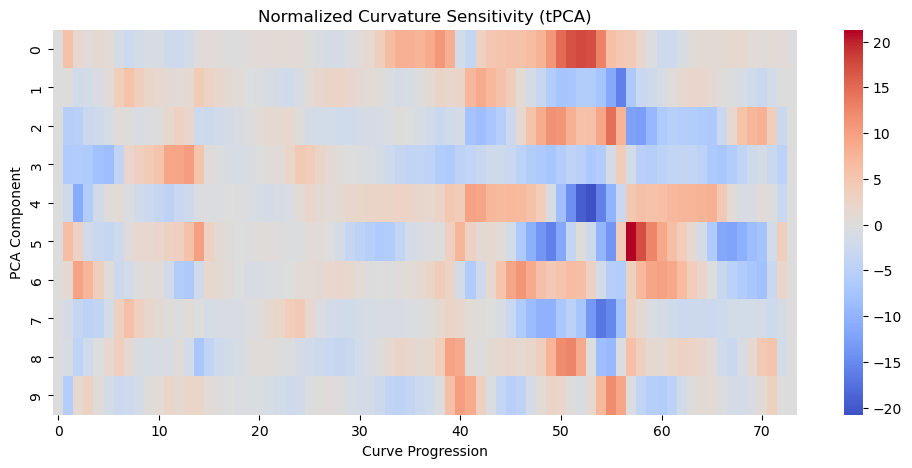

c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


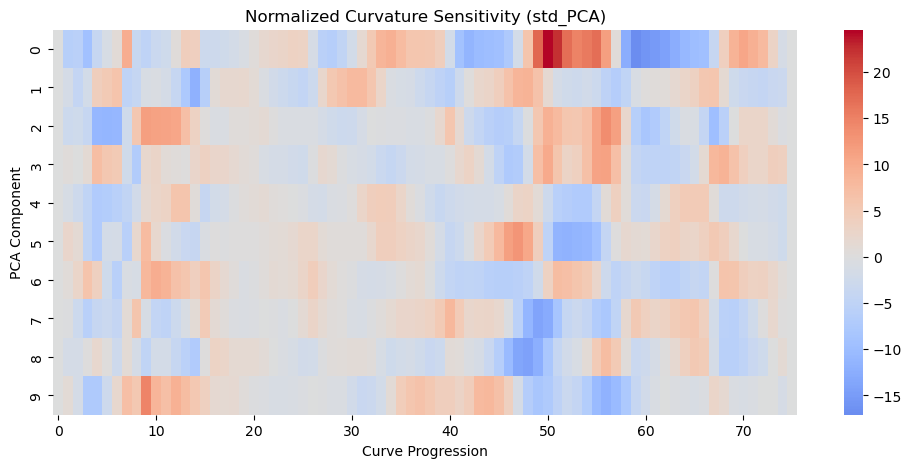

c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


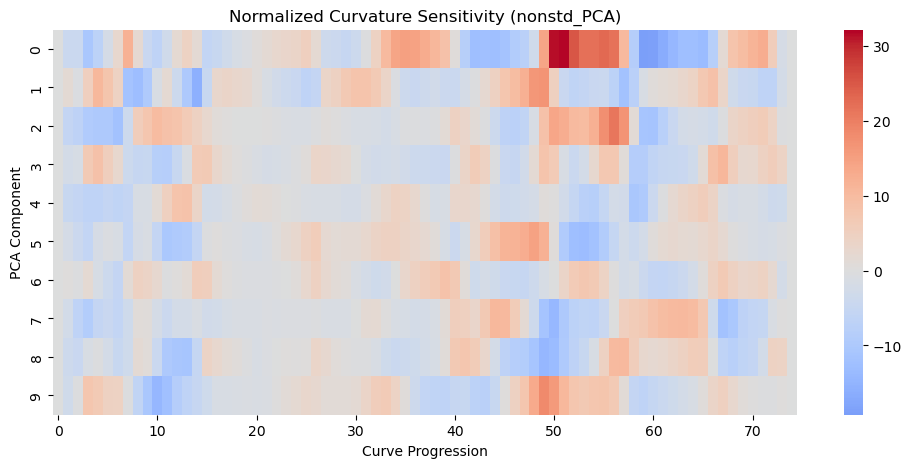

In [164]:
def analyze_and_visualize_norm_sensitivity(synthetic_pca_coeffs, synthetic_curvature, label):
    """
    计算并可视化 PCA 组件对曲率的敏感性。

    参数:
    - synthetic_pca_coeffs: (num_samples, num_pca_components)，PCA 系数
    - synthetic_curvature: (num_samples, num_points)，曲率数据
    - label: 标记当前方法 (e.g., "std_PCA" 或 "nonstd_PCA")
    """

    num_pca_components = synthetic_pca_coeffs.shape[1]
    num_points = synthetic_curvature.shape[1]

    curvature_sensitivity = np.zeros((num_pca_components, num_points))
    normalized_sensitivity = np.zeros((num_pca_components, num_points))

    # 计算曲率的标准差（用于归一化）
    curvature_std = np.std(synthetic_curvature, axis=0)

    for pc_idx in range(num_pca_components):
        for point_idx in range(num_points):
            # 计算 Pearson 相关系数
            curvature_sensitivity[pc_idx, point_idx], _ = pearsonr(synthetic_pca_coeffs[:, pc_idx], synthetic_curvature[:, point_idx])

            # 归一化敏感度（避免受曲率大小影响）
            if curvature_std[point_idx] > 0:
                normalized_sensitivity[pc_idx, point_idx] = curvature_sensitivity[pc_idx, point_idx] / curvature_std[point_idx]
            else:
                normalized_sensitivity[pc_idx, point_idx] = 0

    # 可视化归一化敏感度
    plt.figure(figsize=(12, 5))
    sns.heatmap(normalized_sensitivity, cmap="coolwarm", center=0, annot=False, xticklabels=10, yticklabels=1)
    plt.xlabel("Curve Progression")
    plt.ylabel("PCA Component")
    plt.title(f"Normalized Curvature Sensitivity ({label})")
    plt.show()

    return curvature_sensitivity, normalized_sensitivity


tPCA_curvature_sensitivity, tPCA_normalized_sensitivity = analyze_and_visualize_norm_sensitivity(
    tPCA_synthetic_tpca_coeffs, tPCA_synthetic_curvature, label="tPCA"
)

# 计算并可视化标准化 PCA 的敏感性分析
std_curvature_sensitivity, std_normalized_sensitivity = analyze_and_visualize_norm_sensitivity(
    std_synthetic_pca_coeffs, std_synthetic_curvature, label="std_PCA")

# 计算并可视化非标准化 PCA 的敏感性分析
nonstd_curvature_sensitivity, nonstd_normalized_sensitivity = analyze_and_visualize_norm_sensitivity(
    nonstd_synthetic_pca_coeffs, nonstd_synthetic_curvature, label="nonstd_PCA")